## <h1><center> Introduction </center></h1>

[link](https://archive.ics.uci.edu/ml/datasets/Automobile)
<p><div style = "text-align: justify; font-size: 16px">In this notebook I tried covering the topic of linear regression, addressing, to varying degrees, questions of multicollinearity, autocorrelation, normality etc.</div></p>

<p><div style = "text-align: justify; font-size: 16px"><b>Important note</b>: should you want to maximise predictive accuracy, you have to opt for more sophisticated algorithms. Nevertheless, linear regression is still valuable when it comes to exploring relationships, making statistical inferences and interpreting results of your research.</div></p>

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

import warnings

warnings.simplefilter(action = 'ignore')

### Import and Understand Dataset

In [134]:
kk = pd.read_csv('/Users/chrisguan/Documents/Regression/final_project/dataset/CarPrice_Assignment.csv')
kk.columns

Index(['car_ID', 'symboling', 'CarName', 'fueltype', 'aspiration',
       'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'curbweight', 'enginetype',
       'cylindernumber', 'enginesize', 'fuelsystem', 'boreratio', 'stroke',
       'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'price'],
      dtype='object')

In [139]:
pd.set_option('display.max_columns', None)

In [140]:
kk.head(2)

car_ID  symboling              CarName fueltype aspiration doornumber  \
0       1          3   alfa-romero giulia      gas        std        two   
1       2          3  alfa-romero stelvio      gas        std        two   

       carbody drivewheel enginelocation  wheelbase  carlength  carwidth  \
0  convertible        rwd          front       88.6      168.8      64.1   
1  convertible        rwd          front       88.6      168.8      64.1   

   carheight  curbweight enginetype cylindernumber  enginesize fuelsystem  \
0       48.8        2548       dohc           four         130       mpfi   
1       48.8        2548       dohc           four         130       mpfi   

   boreratio  stroke  compressionratio  horsepower  peakrpm  citympg  \
0       3.47    2.68               9.0         111     5000       21   
1       3.47    2.68               9.0         111     5000       21   

   highwaympg    price  
0          27  13495.0  
1          27  16500.0

In [141]:
### Data
df = pd.read_csv('/Users/chrisguan/Documents/Regression/final_project/dataset/CarPrice_Assignment.csv')

In [49]:
df.shape

(205, 26)

In [33]:
%%capture

#Basic Information
df.shape
df.info()
df.describe()

#Missing Value
df_null = df.isna().mean().round(4) * 100
df_null.sort_values(ascending=False).head()
df.describe()

### Data Cleaning

In [27]:
df['CarName'].head()

0          alfa-romero giulia
1         alfa-romero stelvio
2    alfa-romero Quadrifoglio
3                 audi 100 ls
4                  audi 100ls
Name: CarName, dtype: object

In [142]:
df['CarName'] = df['CarName'].str.split(' ', n=1 ,expand=True).iloc[:,0]
df['CarName'] = df['CarName'].replace({'maxda': 'mazda', 'nissan': 'Nissan', 'porcshce': 'porsche', 'toyouta': 'toyota', 
                            'vokswagen': 'volkswagen', 'vw': 'volkswagen'})
df.CarName.unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'mazda', 'buick', 'mercury', 'mitsubishi',
       'Nissan', 'peugeot', 'plymouth', 'porsche', 'renault', 'saab',
       'subaru', 'toyota', 'volkswagen', 'volvo'], dtype=object)

In [44]:
df = df.drop(columns=['car_ID','symboling','carheight','doornumber'], axis = 1)

In [30]:
df.CarName.unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'mazda', 'buick', 'mercury', 'mitsubishi',
       'Nissan', 'peugeot', 'plymouth', 'porsche', 'renault', 'saab',
       'subaru', 'toyota', 'volkswagen', 'volvo'], dtype=object)

In [143]:
#Split the data into numerical and categorical columns.
Cat_vars = []
Num_vars = []

for col in df.columns:
    if ((df[col].dtype == 'float64') | (df[col].dtype == 'int64')) & (df[col].nunique() > 10):
        Num_vars.append(col)
    else: Cat_vars.append(col)

In [46]:
df.to_csv(r'/Users/chrisguan/Documents/Regression/final_project/cleaned_df.csv', index=False)

In [133]:
df.columns

Index(['CarName', 'fueltype', 'aspiration', 'carbody', 'drivewheel',
       'enginelocation', 'wheelbase', 'carlength', 'carwidth', 'curbweight',
       'enginetype', 'cylindernumber', 'enginesize', 'fuelsystem', 'boreratio',
       'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg',
       'highwaympg', 'price'],
      dtype='object')

In [131]:
df.cylindernumber.unique()

array(['small', 'middle', 'large'], dtype=object)

## <h1><center> Quick [EDA](https://www.kaggle.com/code/hellbuoy/carprice-prediction-mlr-rfe-vif?scriptVersionId=23097683&cellId=30) </center></h1>

(205, 24)

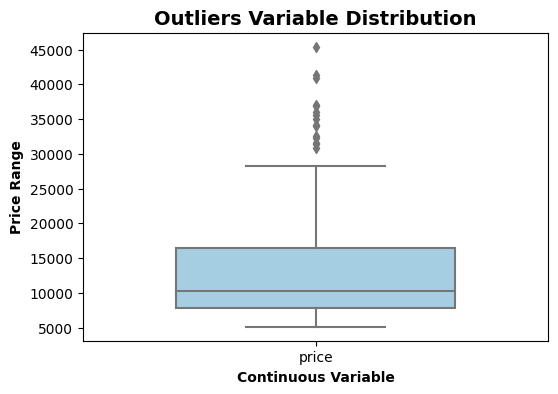

In [11]:
outliers = ['price']
plt.rcParams['figure.figsize'] = [6,4]
sns.boxplot(data=df[outliers], orient="v", palette="Paired" ,whis=1.5, saturation=1, width=0.6)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Price Range", fontweight = 'bold')
plt.xlabel("Continuous Variable", fontweight = 'bold')
df.shape

<AxesSubplot: title={'center': 'Car Price Distribution Plot'}, xlabel='price', ylabel='Density'>

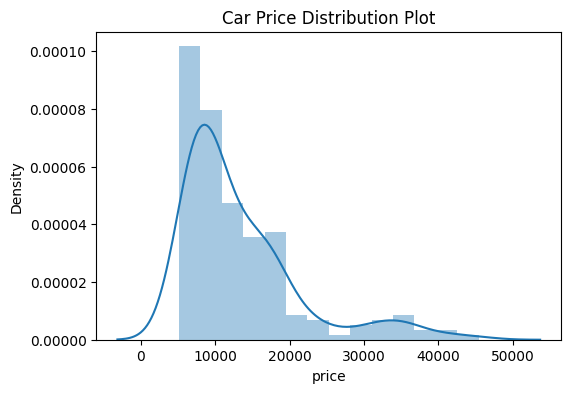

In [12]:
plt.figure(figsize=(6,4))

plt.title('Car Price Distribution Plot')
sns.distplot(df['price'])

Text(0, 0.5, 'Count of Cars')

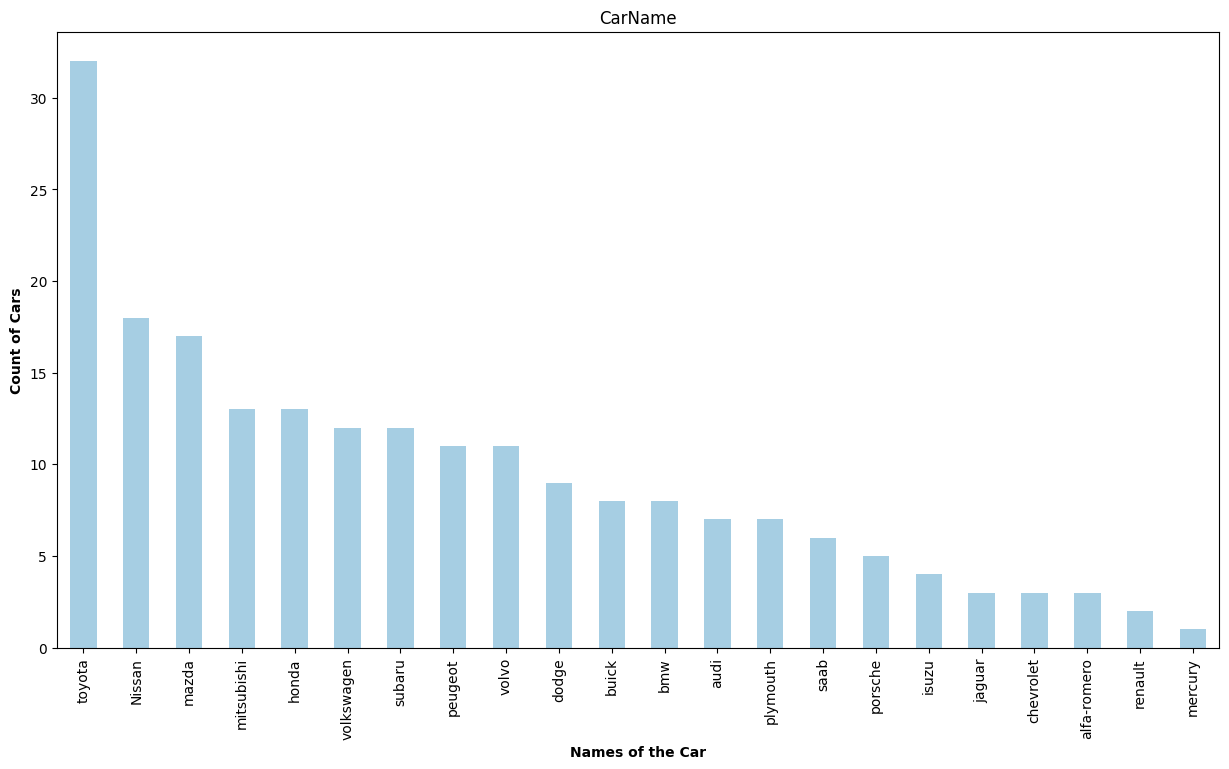

In [13]:
plt.rcParams['figure.figsize'] = [15,8]
ax=df['CarName'].value_counts().plot(kind='bar',stacked=True, colormap = 'Paired')
ax.title.set_text('CarName')
plt.xlabel("Names of the Car",fontweight = 'bold')
plt.ylabel("Count of Cars",fontweight = 'bold')

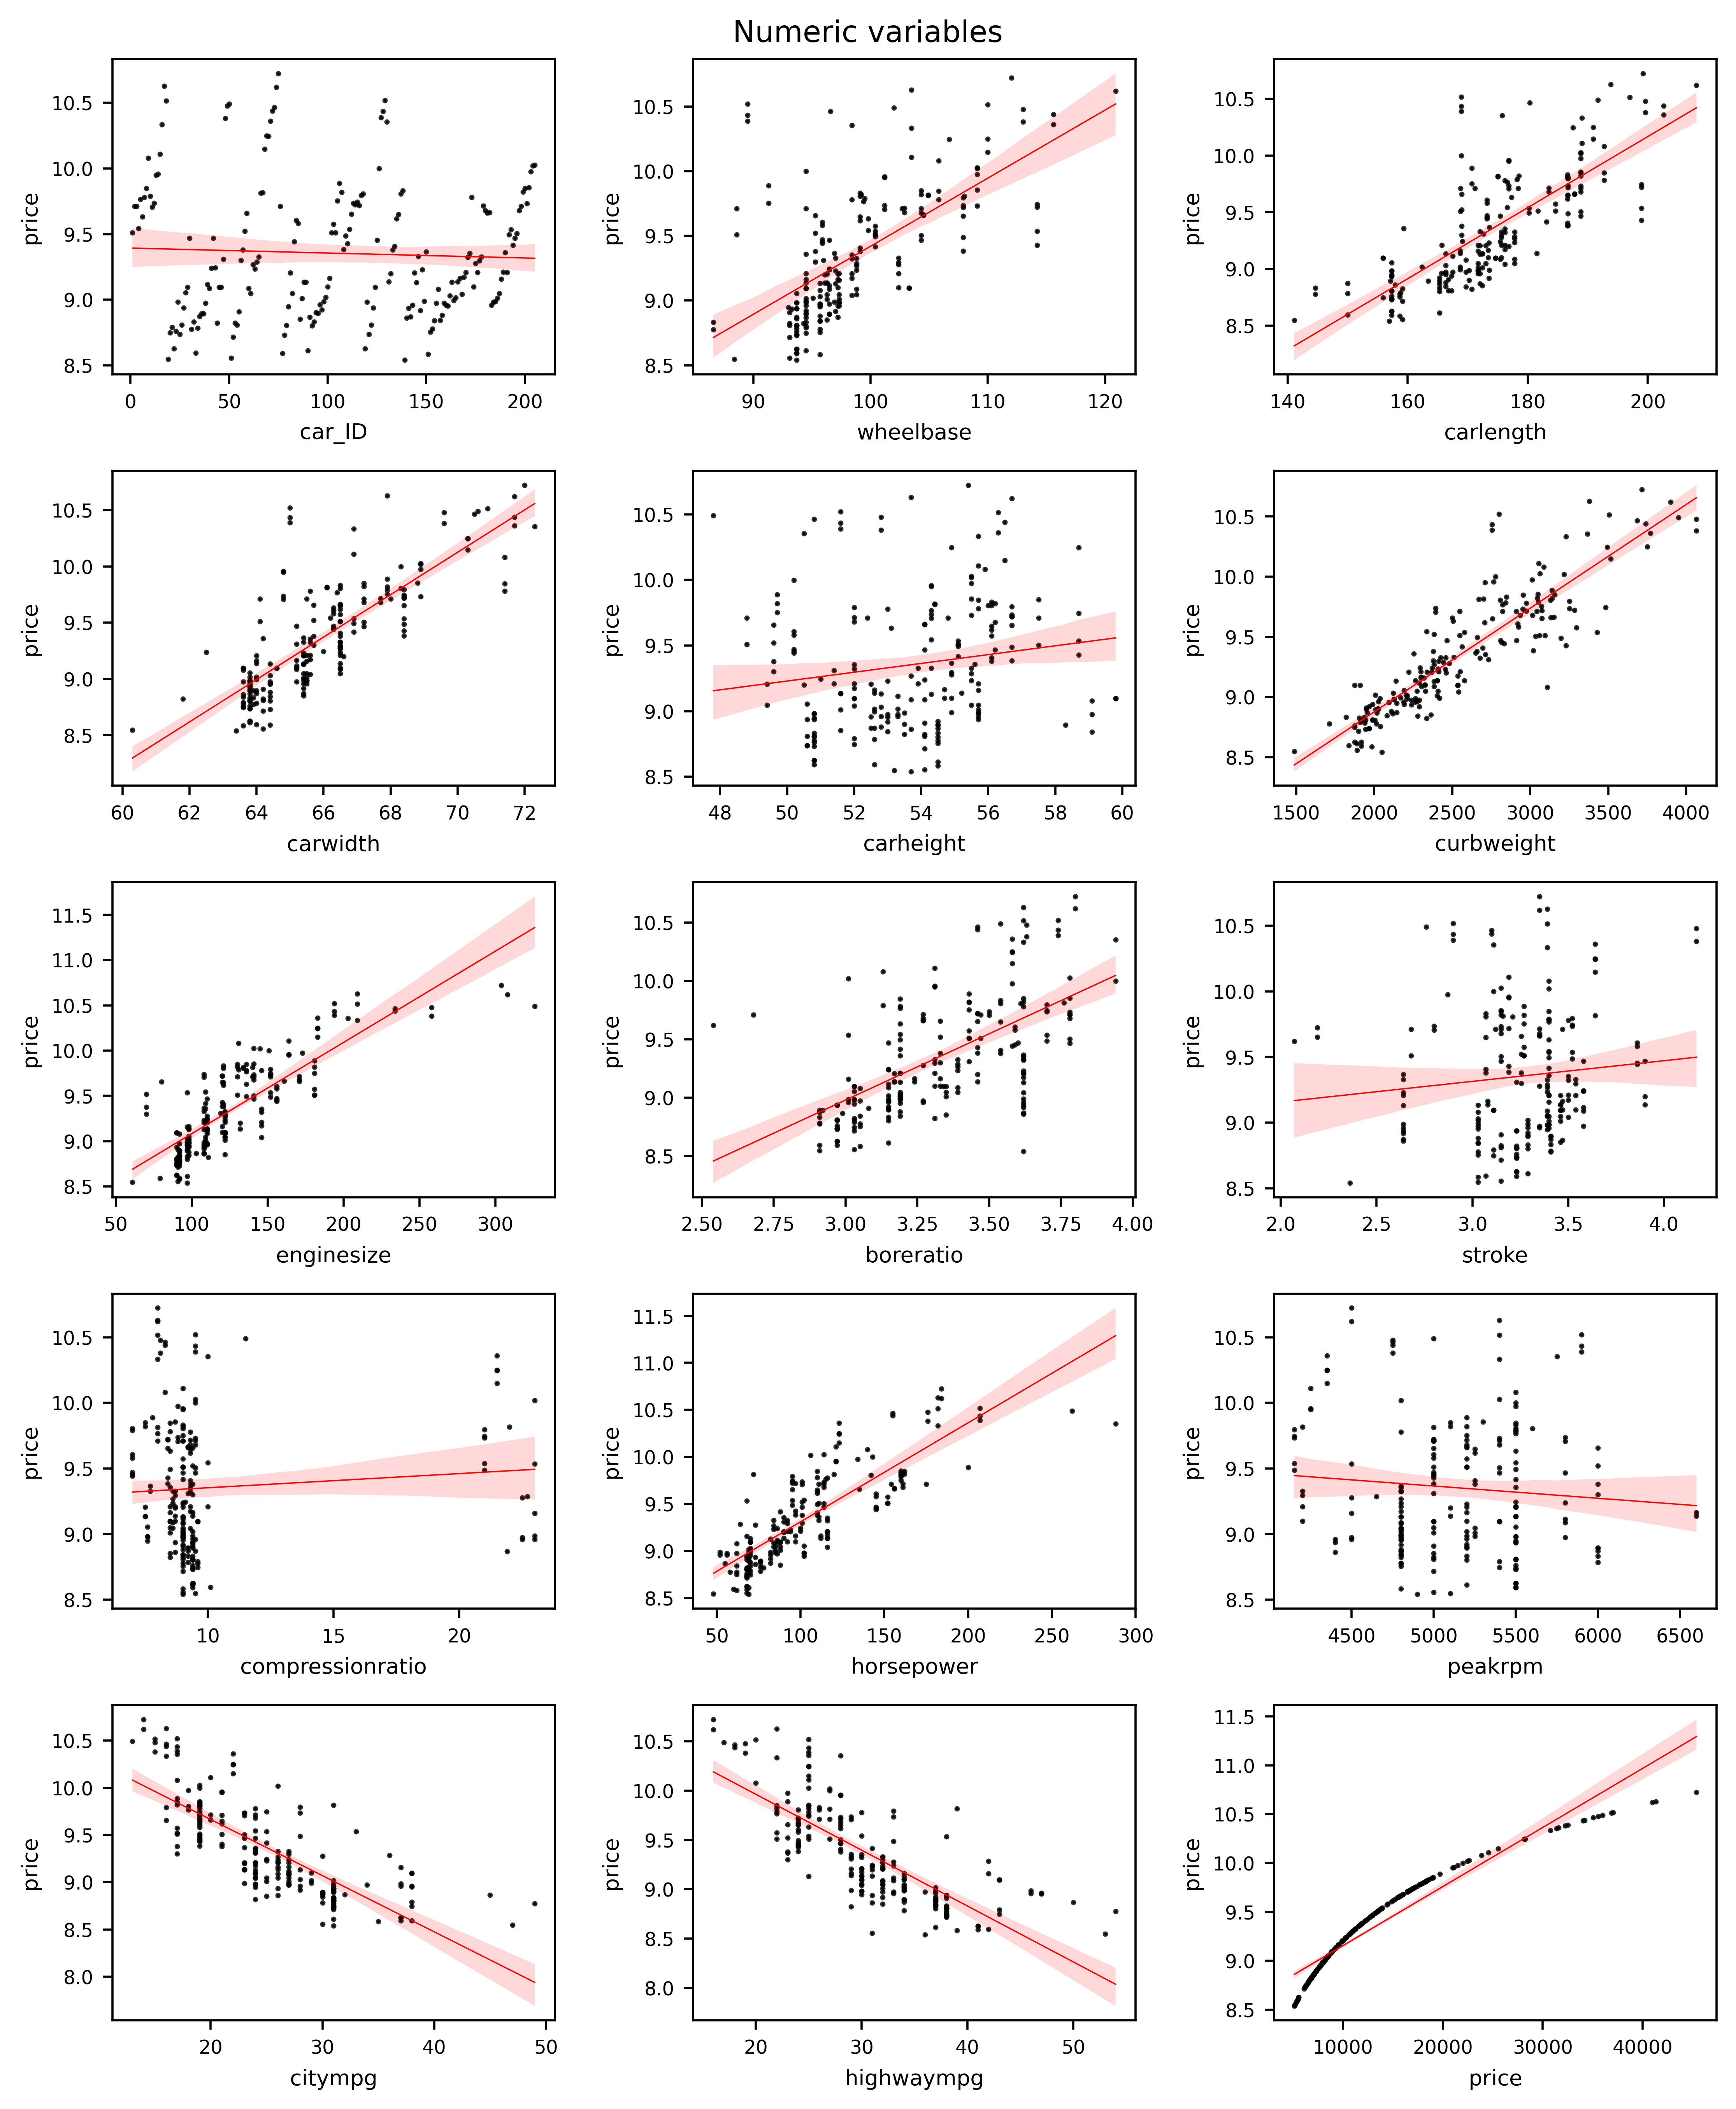

In [148]:
with plt.rc_context(rc = {'figure.dpi': 500, 'axes.labelsize': 8, 
                          'xtick.labelsize': 7, 'ytick.labelsize': 7}): 

    fig_1, ax_1 = plt.subplots(5, 3, figsize = (9, 11))

    for idx, (column, axes) in enumerate(zip(Num_vars, ax_1.flatten())):
    
        sns.regplot(ax = axes, x = df[column], y = np.log(df['price']),
                    scatter_kws = {'s': 1, 'color': 'k'}, 
                    line_kws = {'lw': 0.5, 'color': 'r'})
    
    else:
    
        [axes.set_visible(False) for axes in ax_1.flatten()[idx + 1:]]

    fig_1.suptitle('Numeric variables', fontsize = 11)
    plt.tight_layout(pad = 1)
    plt.show()

**Insights:**
* carwidth, carlength, curbweight, enginesize, and horsepower seem to have a poitive correlation with price.
* carheight and peakrpm doesn't show any significant trend with price.
* citympg and highwaympg seem to have a significant negative correlation with price.

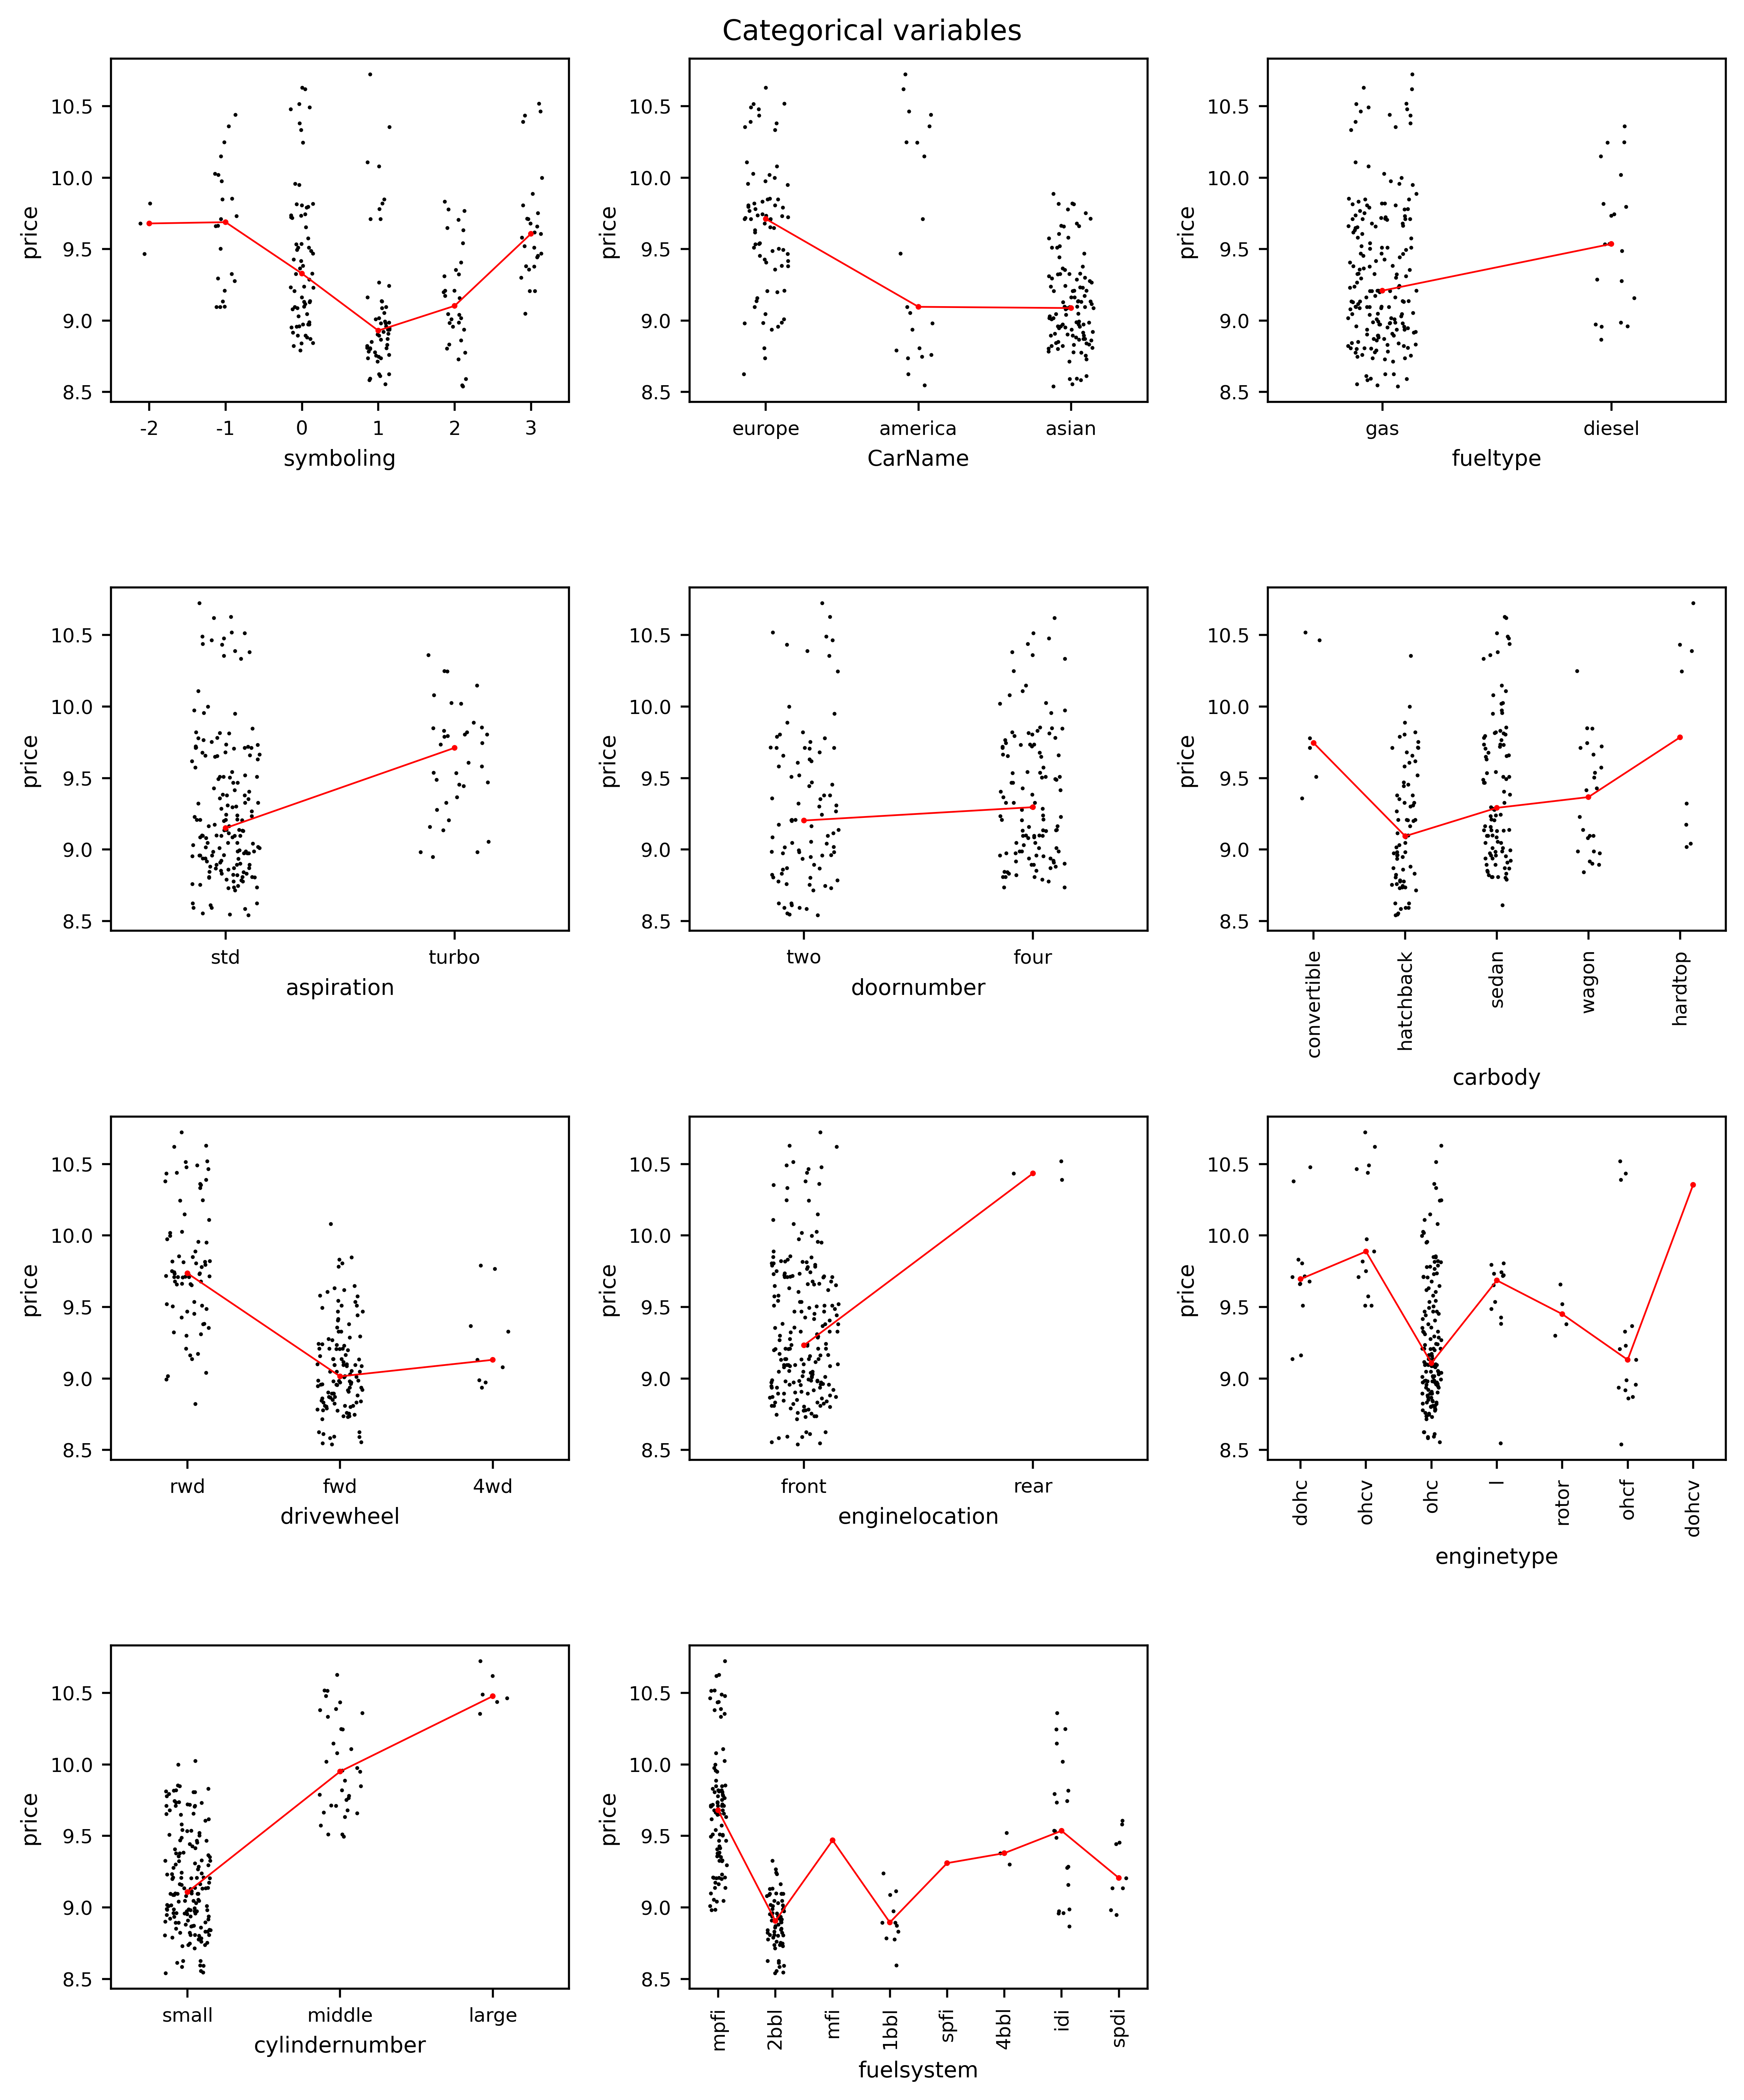

In [147]:
with plt.rc_context(rc = {'figure.dpi': 500, 'axes.labelsize': 8.5, 
                          'xtick.labelsize': 7.5, 'ytick.labelsize': 7.5}): 

    fig_2, ax_2 = plt.subplots(4, 3, figsize = (9.5, 11.5))

    for idx, (column, axes) in enumerate(zip(Cat_vars, ax_2.flatten())):
    
        plt.setp(axes.collections, alpha = 0.1)
    
        sns.stripplot(ax = axes, x = df[column], 
                      y = np.log(df['price']),
                      color = 'k', s = 1.5, alpha = 1,
                      jitter = 0.15)
        
        sns.pointplot(ax = axes, x = df[column],
                      y = np.log(df['price']),
                      color = 'r', scale = 0.25,
                      estimator = np.median, # ci = 'sd', capsize = 0.05,
                      join = True, errwidth = 0)
    
        plt.setp(axes.lines, zorder = 100)
        plt.setp(axes.collections, zorder = 100)
        
        if (df[column].dtypes == 'O') & (df[column].nunique() > 4):
        
            plt.setp(axes.get_xticklabels(), rotation = 90)
    
    else:
    
        [axes.set_visible(False) for axes in ax_2.flatten()[idx + 1:]]

    fig_2.suptitle('Categorical variables', fontsize = 11)
    plt.tight_layout()
    plt.show()

**Insights**
* The cars with fueltype as diesel are comparatively more expensive than the cars with fueltype as gas.
* All the types of carbody is relatively cheaper as compared to convertible carbody.
* The cars with rear enginelocation are way expensive than cars with front enginelocation.
* The price of car is directly proportional to no. of cylinders in most cases.
* Enginetype ohcv comes into higher price range cars.
* DoorNumber isn't affecting the price much.
* HigerEnd cars seems to have rwd drivewheel

<Figure size 2000x600 with 0 Axes>

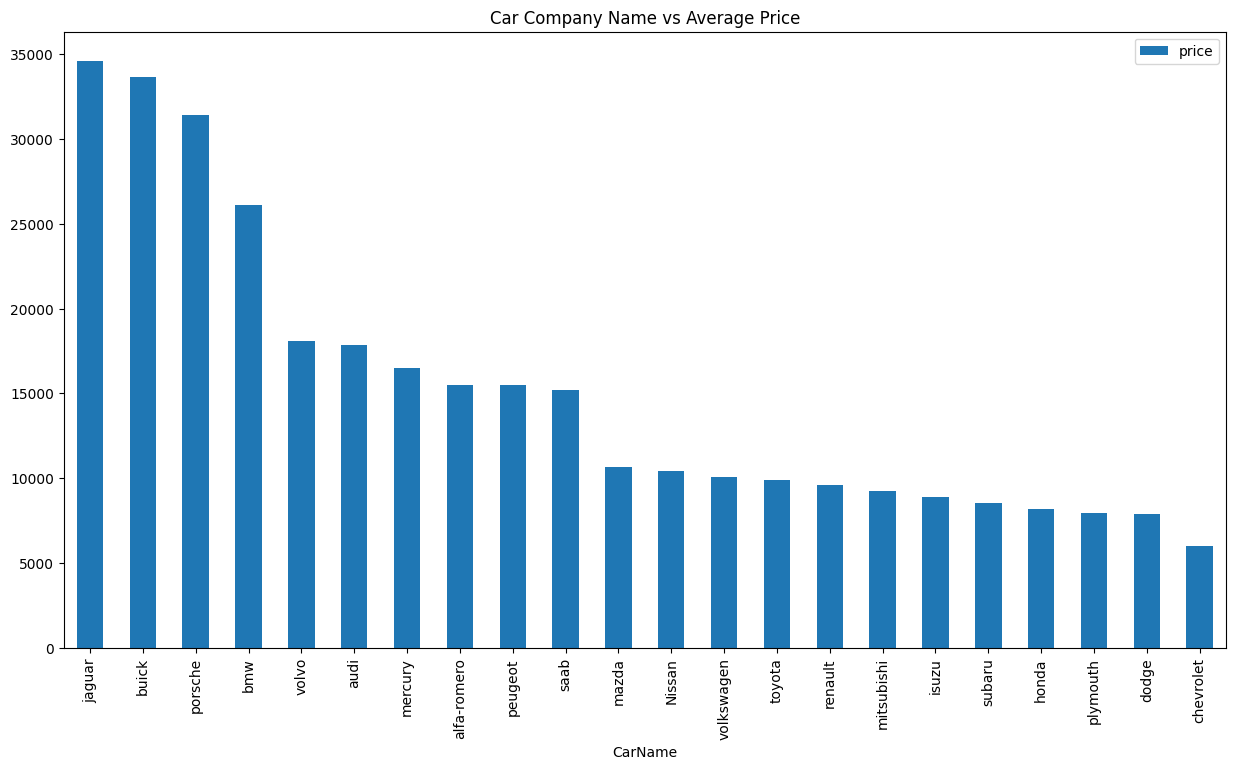

In [38]:
plt.figure(figsize=(20, 6))

df_autox = pd.DataFrame(df.groupby(['CarName'])['price'].mean().sort_values(ascending = False))
df_autox.plot.bar()
plt.title('Car Company Name vs Average Price')
plt.show()

**Significant variables after Visualization**
* Cars_Category , Engine Type, Fuel Type
* Car Body , Aspiration , Cylinder Number
* Drivewheel , Curbweight , Car Length
* Car Length , Car width , Engine Size
* Boreratio , Horse Power , Wheel base
* Citympg , highwaympg , symboling

In [40]:
df_black_magic = df.copy()

df_black_magic['price'] = df_black_magic['price'].astype('int')
df_black_magic_auto_temp = df_black_magic.copy()
t = df_black_magic_auto_temp.groupby(['CarName'])['price'].mean()
df_black_magic_auto_temp = df_black_magic_auto_temp.merge(t.reset_index(), how='left',on='CarName')
bins = [0,10000,20000,40000]
label =['Budget_Friendly','Medium_Range','TopNotch_Cars']
df_black_magic['Cars_Category'] = pd.cut(df_black_magic_auto_temp['price_y'],bins,right=False,labels=label)
df_black_magic

CarName fueltype aspiration doornumber      carbody drivewheel  \
0    alfa-romero      gas        std        two  convertible        rwd   
1    alfa-romero      gas        std        two  convertible        rwd   
2    alfa-romero      gas        std        two    hatchback        rwd   
3           audi      gas        std       four        sedan        fwd   
4           audi      gas        std       four        sedan        4wd   
..           ...      ...        ...        ...          ...        ...   
200        volvo      gas        std       four        sedan        rwd   
201        volvo      gas      turbo       four        sedan        rwd   
202        volvo      gas        std       four        sedan        rwd   
203        volvo   diesel      turbo       four        sedan        rwd   
204        volvo      gas      turbo       four        sedan        rwd   

    enginelocation  wheelbase  carlength  carwidth  ...  fuelsystem  \
0            front       88.6      168.8      64.1  ...        mpfi   
1            front       88.6      168.8      64.1  ...        mpfi   
2            front       94.5      171.2      65.5  ...        mpfi   
3            front       99.8      176.6      66.2  ...        mpfi   
4            front       99.4      176.6      66.4  ...        mpfi   
..             ...        ...        ...       ...  ...         ...   
200          front      109.1      188.8      68.9  ...        mpfi   
201          front      109.1      188.8      68.8  ...        mpfi   
202          front      109.1      188.8      68.9  ...        mpfi   
203          front      109.1      188.8      68.9  ...         idi   
204          front      109.1      188.8      68.9  ...        mpfi   

     boreratio stroke compressionratio  horsepower peakrpm  citympg  \
0         3.47   2.68              9.0         111    5000       21   
1         3.47   2.68              9.0         111    5000       21   
2         2.68   3.47              9.0         154    5000       19   
3         3.19   3.40             10.0         102    5500       24   
4         3.19   3.40              8.0         115    5500       18   
..         ...    ...              ...         ...     ...      ...   
200       3.78   3.15              9.5         114    5400       23   
201       3.78   3.15              8.7         160    5300       19   
202       3.58   2.87              8.8         134    5500       18   
203       3.01   3.40             23.0         106    4800       26   
204       3.78   3.15              9.5         114    5400       19   

     highwaympg  price  Cars_Category  
0            27  13495   Medium_Range  
1            27  16500   Medium_Range  
2            26  16500   Medium_Range  
3            30  13950   Medium_Range  
4            22  17450   Medium_Range  
..          ...    ...            ...  
200          28  16845   Medium_Range  
201          25  19045   Medium_Range  
202          23  21485   Medium_Range  
203          27  22470   Medium_Range  
204          25  22625   Medium_Range  

[205 rows x 25 columns]

## <h1><center> Building models </center></h1>

In [120]:
df

CarName fueltype aspiration      carbody drivewheel enginelocation  \
0    europe      gas        std  convertible        rwd          front   
1    europe      gas        std  convertible        rwd          front   
2    europe      gas        std    hatchback        rwd          front   
3    europe      gas        std        sedan        fwd          front   
4    europe      gas        std        sedan        4wd          front   
..      ...      ...        ...          ...        ...            ...   
200  europe      gas        std        sedan        rwd          front   
201  europe      gas      turbo        sedan        rwd          front   
202  europe      gas        std        sedan        rwd          front   
203  europe   diesel      turbo        sedan        rwd          front   
204  europe      gas      turbo        sedan        rwd          front   

     wheelbase  carlength  carwidth  curbweight  ... enginesize fuelsystem  \
0         88.6      168.8      64.1        2548  ...        130       mpfi   
1         88.6      168.8      64.1        2548  ...        130       mpfi   
2         94.5      171.2      65.5        2823  ...        152       mpfi   
3         99.8      176.6      66.2        2337  ...        109       mpfi   
4         99.4      176.6      66.4        2824  ...        136       mpfi   
..         ...        ...       ...         ...  ...        ...        ...   
200      109.1      188.8      68.9        2952  ...        141       mpfi   
201      109.1      188.8      68.8        3049  ...        141       mpfi   
202      109.1      188.8      68.9        3012  ...        173       mpfi   
203      109.1      188.8      68.9        3217  ...        145        idi   
204      109.1      188.8      68.9        3062  ...        141       mpfi   

     boreratio stroke  compressionratio  horsepower  peakrpm  citympg  \
0         3.47   2.68               9.0         111     5000       21   
1         3.47   2.68               9.0         111     5000       21   
2         2.68   3.47               9.0         154     5000       19   
3         3.19   3.40              10.0         102     5500       24   
4         3.19   3.40               8.0         115     5500       18   
..         ...    ...               ...         ...      ...      ...   
200       3.78   3.15               9.5         114     5400       23   
201       3.78   3.15               8.7         160     5300       19   
202       3.58   2.87               8.8         134     5500       18   
203       3.01   3.40              23.0         106     4800       26   
204       3.78   3.15               9.5         114     5400       19   

     highwaympg    price  
0            27  13495.0  
1            27  16500.0  
2            26  16500.0  
3            30  13950.0  
4            22  17450.0  
..          ...      ...  
200          28  16845.0  
201          25  19045.0  
202          23  21485.0  
203          27  22470.0  
204          25  22625.0  

[205 rows x 22 columns]

In [121]:
df.loc[:, df.columns!='price'].columns

Index(['CarName', 'fueltype', 'aspiration', 'carbody', 'drivewheel',
       'enginelocation', 'wheelbase', 'carlength', 'carwidth', 'curbweight',
       'enginetype', 'cylindernumber', 'enginesize', 'fuelsystem', 'boreratio',
       'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg',
       'highwaympg'],
      dtype='object')

In [122]:
x = df[df.loc[:, df.columns!='price'].columns]
y = df['price']


In [107]:


# from sklearn.linear_model import LinearRegression
# lm = LinearRegression()
# lm.fit(x_train, y_train)
# pred = lm.predict(x_test)
# pred

len(x_train)

184

### Common Functions

In [8]:
# Split to 80-20, fit, print table
def splitFitTable(df):
    np.random.seed(0)
    df_train, df_test = train_test_split(df, train_size = 0.8, test_size = 0.2, random_state = 100)

    train_x = df_train.drop('price',axis=1)
    train_y = df_train['price']

    train_x = sm.add_constant(train_x)

    model1 = sm.OLS(train_y,train_x)
    lm_num_only = model1.fit()
    
    return lm_num_only

In [194]:
def backwardSelection(df, alpha=10): 
    np.random.seed(0)
    df_train, df_test = train_test_split(df, train_size = 0.8, test_size = 0.2, random_state = 100)

    train_x = df_train.drop('price',axis=1)
    train_y = df_train['price']

    lm = LinearRegression()
    lm.fit(train_x, train_y)

    rfe = RFE(lm, n_features_to_select=alpha, step=1)             
    rfe = rfe.fit(train_x, train_y)

    feature_rfe = train_x.columns[rfe.support_].tolist()
    feature_rfe.append('price')
    
    return feature_rfe, splitFitTable(df[feature_rfe])

In [9]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

def linear_assumption(model, features, label):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()
    
    
def normal_errors_assumption(model, features, label, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    from statsmodels.stats.diagnostic import normal_ad
    print('Assumption 2: The error terms are normally distributed', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(model, features, label)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.subplots(figsize=(12, 6))
    plt.title('Distribution of Residuals')
    sns.distplot(df_results['Residuals'])
    plt.show()
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        print()
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')
        
        

def homoscedasticity_assumption(model, features, label):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
    print('Assumption 5: Homoscedasticity of Error Terms', '\n')
    
    print('Residuals should have relative constant variance')
        
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)

    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals')
    plt.show()  

### Only Numerical Columns

In [14]:
df[df.columns[1:]].corr()['price'][:-1].sort_values(ascending=False)

enginesize          0.874145
curbweight          0.835305
horsepower          0.808139
carwidth            0.759325
carlength           0.682920
wheelbase           0.577816
boreratio           0.553173
carheight           0.119336
stroke              0.079443
compressionratio    0.067984
peakrpm            -0.085267
citympg            -0.685751
highwaympg         -0.697599
Name: price, dtype: float64

In [15]:
print(splitFitTable(df[Num_vars]).summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     60.12
Date:                Wed, 07 Dec 2022   Prob (F-statistic):           1.14e-52
Time:                        23:51:29   Log-Likelihood:                -1549.9
No. Observations:                 164   AIC:                             3128.
Df Residuals:                     150   BIC:                             3171.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -4.242e+04   1.66e+04  

In [25]:
#anova is only for reduced model and full model
import statsmodels.api as sm
from statsmodels.formula.api import ols

model_t = ols('price ~ wheelbase', data=df[Num_vars]).fit()
anova_table = sm.stats.anova_lm(model_t, typ=2)
anova_table

sum_sq     df           F        PR(>F)
wheelbase  4.346878e+09    1.0  101.745716  1.182820e-19
Residual   8.672761e+09  203.0         NaN           NaN

### Only Catagorical Columns

In [84]:
# check how many categories present in each feature
featre =[]
num = []

for feature in df[Cat_vars]:
    featre.append(feature)
    num.append(len(df[Cat_vars][feature].unique()))
    
table = pd.DataFrame(zip(featre,num), columns=['Feature','Unique Words']).T
table.columns = table.iloc[0]
table.drop(index='Feature')

Feature      symboling CarName fueltype aspiration doornumber carbody  \
Unique Words         6      22        2          2          2       5   

Feature      drivewheel enginelocation enginetype cylindernumber fuelsystem  
Unique Words          3              2          7              7          8

In [71]:
df_col = df[Cat_vars]
df_col['price'] = df['price']

df_car_dummy = pd.get_dummies(df_col)
print(splitFitTable(df_car_dummy).summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     30.98
Date:                Tue, 06 Dec 2022   Prob (F-statistic):           3.09e-47
Time:                        16:25:33   Log-Likelihood:                -1481.4
No. Observations:                 164   AIC:                             3063.
Df Residuals:                     114   BIC:                             3218.
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  4901.74

### All Columns

In [138]:
df_full_dummy = pd.get_dummies(df)
print(splitFitTable(df_full_dummy).summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     68.61
Date:                Thu, 08 Dec 2022   Prob (F-statistic):           1.31e-62
Time:                        14:52:11   Log-Likelihood:                -1397.3
No. Observations:                 164   AIC:                             2915.
Df Residuals:                     104   BIC:                             3101.
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -75.77

##### R^2 is amazing.
But the number of columns is too much. How can you input so many variables when you want to predict the price of your car.

In [139]:
print(backwardSelection(df_full_dummy, alpha = 15)[1].summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     90.97
Date:                Thu, 08 Dec 2022   Prob (F-statistic):           1.61e-65
Time:                        14:52:21   Log-Likelihood:                -1514.6
No. Observations:                 164   AIC:                             3059.
Df Residuals:                     149   BIC:                             3106.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -9535.8864 

In [156]:
x_list = backwardSelection(df_full_dummy, alpha = 15)[1].pvalues.index.tolist()
y_list = 'price'

x_list = backwardSelection(df_full_dummy, alpha = 15)[1].pvalues.index.tolist()[1:]
y = ['price']

df_train, df_test = train_test_split(df_full_dummy, train_size = 0.8, test_size = 0.2, random_state = 100)

model1 = sm.OLS(df_full_dummy[y],df_full_dummy[x_list])
test_model = model1.fit()

##### Combination

In [406]:
from itertools import chain, combinations

iterable = df_full_dummy.columns.to_list()

def powerset(iterable):
    #"powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    return chain.from_iterable(combinations(iterable, r) for r in range(len(iterable)+1))

powerset(iterable)



for subset in powerset(X.columns):
    if len(subset) > 0:
        model = sm.OLS(y, X[list(subset)]).fit()

In [ ]:
np.random.seed(0)
    df_train, df_test = train_test_split(df, train_size = 0.8, test_size = 0.2, random_state = 100)

    train_x = df_train.drop('price',axis=1)
    train_y = df_train['price']

    train_x = sm.add_constant(train_x)
    

for subset in powerset(X.columns):
    if len(subset) > 0:
        model = sm.OLS(y, X[list(subset)]).fit()


# Split to 80-20, fit, print table
def splitFitTable(df):
    np.random.seed(0)
    df_train, df_test = train_test_split(df, train_size = 0.8, test_size = 0.2, random_state = 100)

    train_x = df_train.drop('price',axis=1)
    train_y = df_train['price']

    train_x = sm.add_constant(train_x)

    model1 = sm.OLS(train_y,train_x)
    lm_num_only = model1.fit()
    
    return lm_num_only

### Forward Selection

In [898]:
feature = ['horsepower','price']
print(splitFitTable(df[feature]).summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     314.9
Date:                Sun, 04 Dec 2022   Prob (F-statistic):           7.96e-40
Time:                        10:41:37   Log-Likelihood:                -1611.1
No. Observations:                 164   AIC:                             3226.
Df Residuals:                     162   BIC:                             3232.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3283.9152    969.916     -3.386      0.0

In [899]:
feature = ['horsepower', 'curbweight', 'enginesize', 'price']
print(splitFitTable(df[feature]).summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     223.5
Date:                Sun, 04 Dec 2022   Prob (F-statistic):           5.60e-57
Time:                        10:41:46   Log-Likelihood:                -1564.6
No. Observations:                 164   AIC:                             3137.
Df Residuals:                     160   BIC:                             3150.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.368e+04   1434.568     -9.537      0.0

### Edit Variables

##### Bacward Selection

In [145]:
df = df.copy()

df['CarName'] = np.where(
    (df.CarName == 'alfa-romero') | 
    ( df.CarName == 'audi' ) | 
    ( df.CarName == 'bmw' ) | 
    ( df.CarName == 'jaguar' ) | 
    ( df.CarName == 'peugeot' ) | 
    ( df.CarName == 'plymouth' ) | 
    ( df.CarName == 'porsche' ) | 
    ( df.CarName == 'peugeot' ) | 
    ( df.CarName == 'saab' ) | 
    ( df.CarName == 'volkswagen' ) | 
    ( df.CarName == 'volvo' ) | 
    ( df.CarName == 'renault' ),
    'europe',df.CarName)

df['CarName'] = np.where(
    (df.CarName == 'chevrolet') | 
    ( df.CarName == 'dodge' ) | 
    ( df.CarName == 'buick' ) | 
    ( df.CarName == 'mercury' ) | 
    ( df.CarName == 'three' ) | 
    ( df.CarName == 'three' ) | 
    ( df.CarName == 'three' ) | 
    ( df.CarName == 'four' ),
    'america',df.CarName)

df['CarName'] = np.where(
    (df.CarName == 'honda') | 
    ( df.CarName == 'isuzu' ) | 
    ( df.CarName == 'mazda' ) | 
    ( df.CarName == 'mitsubishi' ) | 
    ( df.CarName == 'Nissan' ) | 
    ( df.CarName == 'subaru' ) | 
    ( df.CarName == 'toyota' ) | 
    ( df.CarName == 'four' ),
    'asian',df.CarName)

In [113]:
df_region_dummy = pd.get_dummies(df_region)
print(splitFitTable(df_region_dummy).summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     55.63
Date:                Thu, 08 Dec 2022   Prob (F-statistic):           9.59e-62
Time:                        12:41:28   Log-Likelihood:                -1455.3
No. Observations:                 164   AIC:                             2995.
Df Residuals:                     122   BIC:                             3125.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -4296.45

In [146]:
df['cylindernumber'] = np.where(
    (df.cylindernumber == 'two') | 
    ( df.cylindernumber == 'three' ) | 
    ( df.cylindernumber == 'four' ),
    'small',df.cylindernumber)

df['cylindernumber'] = np.where(
    (df.cylindernumber == 'five') |  
    ( df.cylindernumber == 'six' ),
    'middle',df.cylindernumber)

df['cylindernumber'] = np.where(
    (df.cylindernumber == 'twelve') |  
    ( df.cylindernumber == 'eight' ),
    'large',df.cylindernumber)

In [115]:
df_region_dummy = pd.get_dummies(df_region)
print(splitFitTable(df_region_dummy).summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     44.96
Date:                Thu, 08 Dec 2022   Prob (F-statistic):           1.46e-56
Time:                        12:41:30   Log-Likelihood:                -1479.4
No. Observations:                 164   AIC:                             3037.
Df Residuals:                     125   BIC:                             3158.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -5660.40

In [116]:
df_region['fuelsystem'] = np.where(
    (df_region.fuelsystem == 'mpfi') | 
    ( df_region.fuelsystem == 'mfi' ),
    'mfi',df_region.fuelsystem)

df_region['fuelsystem'] = np.where(
    (df_region.fuelsystem == 'spfi') | 
    ( df_region.fuelsystem == 'spdi' ),
    'spi',df_region.fuelsystem)

df_region['fuelsystem'] = np.where(
    (df_region.fuelsystem == '1bbl') |  
    ( df_region.fuelsystem == '2bbl') |
    (df_region.fuelsystem == '4bbl'),
    'bbl',df_region.fuelsystem)

In [117]:
df_region_dummy = pd.get_dummies(df_region)
print(splitFitTable(df_region_dummy).summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     49.16
Date:                Thu, 08 Dec 2022   Prob (F-statistic):           1.12e-58
Time:                        12:41:32   Log-Likelihood:                -1480.7
No. Observations:                 164   AIC:                             3033.
Df Residuals:                     128   BIC:                             3145.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -6414.67

In [126]:
df_region.columns.tolist()

['CarName',
 'fueltype',
 'aspiration',
 'doornumber',
 'carbody',
 'drivewheel',
 'enginelocation',
 'wheelbase',
 'carlength',
 'carwidth',
 'carheight',
 'curbweight',
 'enginetype',
 'cylindernumber',
 'enginesize',
 'fuelsystem',
 'boreratio',
 'stroke',
 'compressionratio',
 'horsepower',
 'peakrpm',
 'citympg',
 'highwaympg',
 'price']

In [128]:
df_region = df_region.drop(columns = ['doornumber', 'wheelbase'])
print(splitFitTable(pd.get_dummies(df_region)).summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     52.58
Date:                Thu, 08 Dec 2022   Prob (F-statistic):           3.21e-60
Time:                        12:51:36   Log-Likelihood:                -1481.2
No. Observations:                 164   AIC:                             3030.
Df Residuals:                     130   BIC:                             3136.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -7214.14

In [133]:
df_region = df_region.drop(columns = ['enginetype'])
print(splitFitTable(pd.get_dummies(df_region)).summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     44.17
Date:                Thu, 08 Dec 2022   Prob (F-statistic):           1.96e-54
Time:                        12:56:19   Log-Likelihood:                -1512.8
No. Observations:                 164   AIC:                             3082.
Df Residuals:                     136   BIC:                             3168.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.041e+

##### Black Magic

In [195]:
df_black_magic = df.copy()

df_black_magic['price'] = df_black_magic['price'].astype('int')
df_black_magic_auto_temp = df_black_magic.copy()
t = df_black_magic_auto_temp.groupby(['CarName'])['price'].mean()
df_black_magic_auto_temp = df_black_magic_auto_temp.merge(t.reset_index(), how='left',on='CarName')
bins = [0,10000,20000,40000]
label =['Budget_Friendly','Medium_Range','TopNotch_Cars']
df_black_magic['Cars_Category'] = pd.cut(df_black_magic_auto_temp['price_y'],bins,right=False,labels=label)
df_black_magic.head(2)

CarName fueltype aspiration doornumber      carbody drivewheel  \
0  alfa-romero      gas        std        two  convertible        rwd   
1  alfa-romero      gas        std        two  convertible        rwd   

  enginelocation  wheelbase  carlength  carwidth  ...  fuelsystem  boreratio  \
0          front       88.6      168.8      64.1  ...        mpfi       3.47   
1          front       88.6      168.8      64.1  ...        mpfi       3.47   

  stroke compressionratio  horsepower peakrpm  citympg  highwaympg  price  \
0   2.68              9.0         111    5000       21          27  13495   
1   2.68              9.0         111    5000       21          27  16500   

   Cars_Category  
0   Medium_Range  
1   Medium_Range  

[2 rows x 25 columns]

In [196]:
df_black_magic = df_black_magic.drop(['CarName'], axis=1)

df_black_magic['cylindernumber'] = np.where(
    (df_black_magic.cylindernumber == 'two') | 
    ( df_black_magic.cylindernumber == 'three' ) | 
    ( df_black_magic.cylindernumber == 'four' ),
    'small',df_black_magic.cylindernumber)

df_black_magic['cylindernumber'] = np.where(
    (df_black_magic.cylindernumber == 'five') |  
    ( df_black_magic.cylindernumber == 'six' ),
    'middle',df_black_magic.cylindernumber)

df_black_magic['cylindernumber'] = np.where(
    (df_black_magic.cylindernumber == 'twelve') |  
    ( df_black_magic.cylindernumber == 'eight' ),
    'large',df_black_magic.cylindernumber)

In [197]:
df_black_magic_dummy = pd.get_dummies(df_black_magic)
print(splitFitTable(df_black_magic_dummy).summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     65.60
Date:                Thu, 08 Dec 2022   Prob (F-statistic):           4.63e-66
Time:                        15:55:07   Log-Likelihood:                -1450.2
No. Observations:                 164   AIC:                             2978.
Df Residuals:                     125   BIC:                             3099.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [166]:
print(backwardSelection(df_black_magic_dummy, alpha = 13)[1].summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     100.0
Date:                Thu, 08 Dec 2022   Prob (F-statistic):           9.09e-64
Time:                        15:18:37   Log-Likelihood:                -1526.7
No. Observations:                 164   AIC:                             3077.
Df Residuals:                     152   BIC:                             3115.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [198]:
magic_list = ['price', 'horsepower', 'carwidth', 'Cars_Category_TopNotch_Cars', 'carbody_hatchback', 'enginetype_dohcv']
print(splitFitTable(df_black_magic_dummy[magic_list]).summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     323.2
Date:                Thu, 08 Dec 2022   Prob (F-statistic):           4.98e-81
Time:                        15:55:24   Log-Likelihood:                -1501.3
No. Observations:                 164   AIC:                             3015.
Df Residuals:                     158   BIC:                             3033.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [175]:
linear_x = df_black_magic_dummy[magic_list].drop('price',axis=1)
linear_y = df_black_magic_dummy['price']

linear_model = LinearRegression()
linear_model.fit(linear_x, linear_y)

LinearRegression()

In [176]:
linear_model.score(linear_x, linear_y)

0.9131235944045905

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


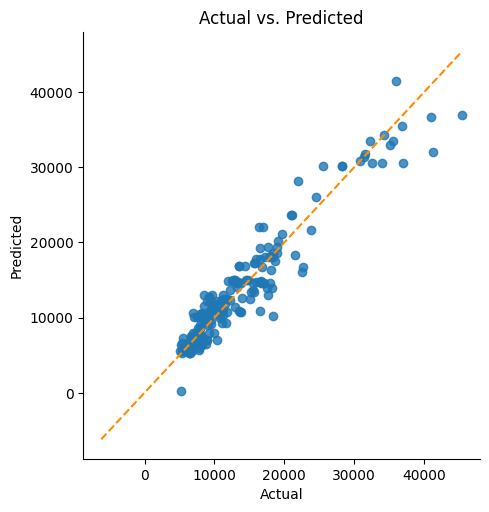

In [182]:
linear_assumption(linear_model, linear_x, linear_y)

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 1.7542948780893378e-05
Residuals are not normally distributed


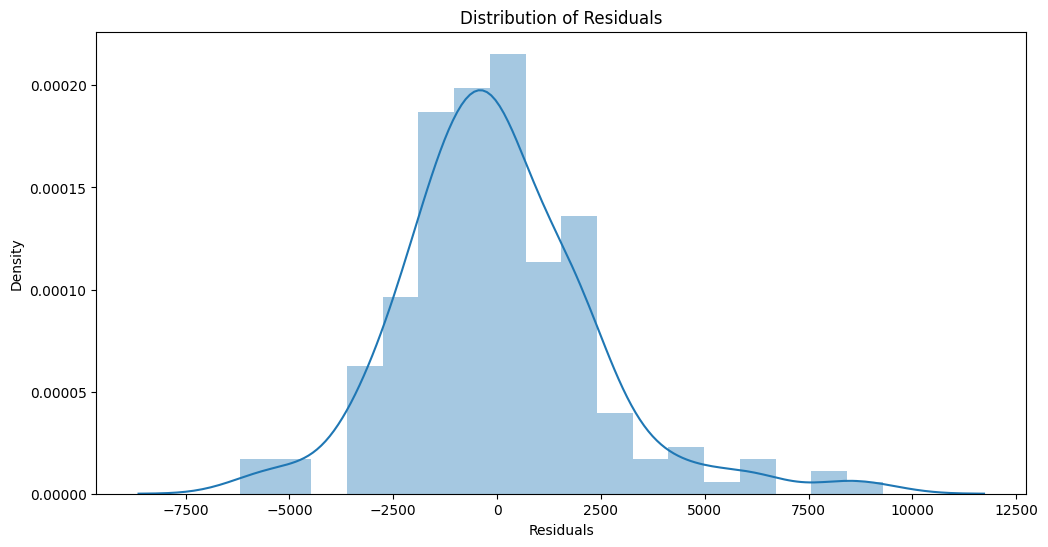


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables


In [184]:
normal_errors_assumption(linear_model, linear_x, linear_y, 0.05)

Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


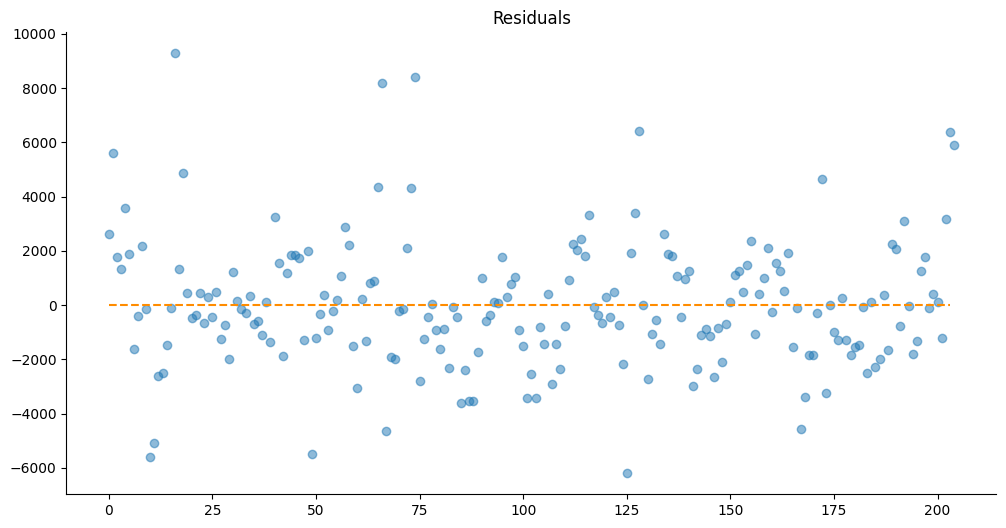

In [186]:
homoscedasticity_assumption(linear_model, linear_x, linear_y)

In [ ]:
df_black_magic_dummy['log price'] = np.log(df_black_magic_dummy['price'])
model_1_results = pd.DataFrame({'log price fitted': model_1_pred, 'residuals': model_1_fit.resid})

with plt.rc_context(rc = {'figure.dpi': 500, 'axes.labelsize': 10, 
                          'xtick.labelsize': 9, 'ytick.labelsize': 9}): 

    fig_3, ax_3 = plt.subplots(3, 3, figsize = (10.5, 9))
    ax_flat = ax_3.flatten()
    
    ### Plots № 1 - 3
    
    sns.scatterplot(ax = ax_flat[0], y = model_1_results['residuals'], x = df['horsepower'], 
                    s = 9.5, color = 'k')
    
    ax_flat[0].set_title('a) Residuals vs $X_5$', fontsize = 11, color = 'black')
    ax_flat[0].axvspan(xmin = 250, xmax = 300, 
                       ymin = 0.02, ymax = 0.27, 
                       alpha = 0.2, color = 'red')
    
    sns.scatterplot(ax = ax_flat[1], y = model_1_results['residuals'], x = df['wheelbase'],
                    s = 9.5, color = 'k')
    
    ax_flat[1].set_title('b) Residuals vs $X_6$', fontsize = 11, color = 'black')

    sns.scatterplot(ax = ax_flat[2], y = model_1_results['residuals'], 
                    x = model_1_results['log price fitted'], s = 9.5, color = 'k')
    
    ax_flat[2].set_title('c) Residuals vs $\hatY$', fontsize = 11, color = 'black')
    ax_flat[2].axvspan(xmin = 10.5, xmax = 11, 
                       ymin = 0.02, ymax = 0.27, 
                       alpha = 0.2, color = 'red')
    
    ### Plots № 3 - 6
    
    sns.scatterplot(ax = ax_flat[3], y = model_1_results['residuals'], x = Y.index,
                    s = 9.5, color = 'k')
    
    ax_flat[3].set_title('d) Residual scatterplot', fontsize = 11, color = 'black')
    
    sns.histplot(ax = ax_flat[4], x = model_1_results['residuals'], kde = True,
                 color = 'k')
    
    ax_flat[4].set_title('e) Residual histogram', fontsize = 11, color = 'black')
    
    sm.qqplot(model_1_results['residuals'], line = 'q', markerfacecolor = 'k', 
              markeredgecolor = 'k', markersize = 2, ax = ax_flat[5])
    
    ax_flat[5].set_title('f) Residual qq-plot', fontsize = 11, color = 'black')
    
    ### Plot № 7
    
    sns.scatterplot(ax = ax_flat[6], y = model_1_results['residuals'], x = df['log price'],
                    s = 9.5, color = 'k')
    
    ax_flat[6].set_title('g) Residuals vs $Y$', fontsize = 11, color = 'black')
    x_1 = np.linspace(8.5, 10.5, 100)
    ax_flat[6].plot(x_1, -0.01*(x_1/2)**2 - 0.2, color = 'r', linestyle = '--')
    ax_flat[6].plot(x_1, +0.05*(x_1/2)**2 - 0.75, color = 'r', linestyle = '--')
    
    [axes.set_visible(False) for axes in ax_flat[7:]]
    
    fig_3.suptitle('Residual analysis', fontsize = 12)
    plt.tight_layout(pad = 1)
    plt.show()

### RFE (Recursive Feature Elimination)

In [901]:
np.random.seed(0)
df_train, df_test = train_test_split(new_full_df, train_size = 0.8, test_size = 0.2, random_state = 100)

train_x = df_train.drop('price',axis=1)
train_y = df_train['price']

# train_x = sm.add_constant(train_x)
# model1 = sm.OLS(train_y,train_x)
# fit = model1.fit()

In [902]:
lm = LinearRegression()
lm.fit(train_x, train_y)

rfe = RFE(lm, n_features_to_select= 15, step=1)             
rfe = rfe.fit(train_x, train_y)

In [903]:
feature_rfe = train_x.columns[rfe.support_].tolist()
feature_rfe.append('price')
feature_rfe

['carwidth',
 'boreratio',
 'stroke',
 'fueltype_diesel',
 'aspiration_std',
 'carbody_convertible',
 'drivewheel_rwd',
 'enginetype_dohcv',
 'enginetype_ohcf',
 'enginetype_rotor',
 'cylindernumber_large',
 'cylindernumber_small',
 'Cars_Category_Budget_Friendly',
 'Cars_Category_Medium_Range',
 'Cars_Category_TopNotch_Cars',
 'price']

In [908]:
print(coef_table(new_full_df[feature_rfe]).summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     113.7
Date:                Sun, 04 Dec 2022   Prob (F-statistic):           5.33e-72
Time:                        10:47:14   Log-Likelihood:                -1498.1
No. Observations:                 164   AIC:                             3026.
Df Residuals:                     149   BIC:                             3073.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [920]:
new_feature_list = coef_table(new_full_df[new_feature_list]).pvalues.rename(index={'const':'price'}).sort_values(ascending=False).index.tolist()[1:]
print(coef_table(new_full_df[new_feature_list]).summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     194.4
Date:                Sun, 04 Dec 2022   Prob (F-statistic):           9.92e-77
Time:                        10:56:37   Log-Likelihood:                -1502.8
No. Observations:                 164   AIC:                             3024.
Df Residuals:                     155   BIC:                             3051.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [921]:
new_full_df[new_feature_list]

Cars_Category_TopNotch_Cars  boreratio  aspiration_std  drivewheel_rwd  \
0                              0       3.47               1               1   
1                              0       3.47               1               1   
2                              0       2.68               1               1   
3                              0       3.19               1               0   
4                              0       3.19               1               0   
..                           ...        ...             ...             ...   
200                            0       3.78               1               1   
201                            0       3.78               0               1   
202                            0       3.58               1               1   
203                            0       3.01               0               1   
204                            0       3.78               0               1   

     carbody_convertible  price  carwidth  Cars_Category_Medium_Range  \
0                      1  13495      64.1                           1   
1                      1  16500      64.1                           1   
2                      0  16500      65.5                           1   
3                      0  13950      66.2                           1   
4                      0  17450      66.4                           1   
..                   ...    ...       ...                         ...   
200                    0  16845      68.9                           1   
201                    0  19045      68.8                           1   
202                    0  21485      68.9                           1   
203                    0  22470      68.9                           1   
204                    0  22625      68.9                           1   

     cylindernumber_small  Cars_Category_Budget_Friendly  
0                       1                              0  
1                       1                              0  
2                       0                              0  
3                       1                              0  
4                       0                              0  
..                    ...                            ...  
200                     1                              0  
201                     1                              0  
202                     0                              0  
203                     0                              0  
204                     1                              0  

[205 rows x 10 columns]

# Other Attemptions

## 1. Multicollinearity <a class="anchor" id = "III_1"></a>

<p><div style = "text-align: justify; font-size: 16px">After the first model was built, the following warning appeared:</div></p>

```
[2] The condition number is large, 2.89e+03. This might indicate that there are strong multicollinearity or other numerical problems.
```

<p><div style = "text-align: justify; font-size: 16px">When we use regression for interpreting results, we need to address multicollinearity, otherwise our coefficients may become unstable, despite the fact that the efficacy of the model itself is not affected. However, it is important to remember that not every case of multicollinearity results in the aforementioned issues.</div></p>

### 1.1 Standard errors and $VIF$

<p><div style = "text-align: justify; font-size: 16px">Before starting hectically deleting collinear variables, analyse their standard errors and explore what happens with coefficients if you temporarily remove one of such regressors from the model:</div></p>

<p><div style = "text-align: justify; font-size: 16px">For instance, both <span style="color:#003ba8">horsepower</span> and <span style="color:#003ba8">wheelbase</span> were positively correlated with the target variable and each other. Nonetheless, their standard errors were not inflated. One can see it by comparing $\widehat{se}(\hat{β}_i)$ to $\hat{β}_i$:</div></p>

$$Horsepower: \frac{\widehat{se}(\hat{β}_5)}{\hat{β}_5} = \frac{0.000468}{0.007775}×100 = 6.016\text{%}$$

$$Wheelbase: \frac{\widehat{se}(\hat{β}_6)}{\hat{β}_6} = \frac{0.002908}{0.027494}×100 = 10.576\text{%}$$

<p><div style = "text-align: justify; font-size: 16px">Following that, I created and compared 2 models: with <span style="color:#003ba8">horsepower</span> but without <span style="color:#003ba8">wheelbase</span> and vice versa.</div></p>

In [5]:
model_1_a = sm.OLS(endog = np.log(Y), exog = sm.add_constant(X.drop('horsepower', axis = 1)))
model_1_a_fit = model_1_a.fit()

model_1_b = sm.OLS(endog = np.log(Y), exog = sm.add_constant(X.drop('wheelbase', axis = 1)))
model_1_b_fit = model_1_b.fit()

pd.DataFrame([model_1_fit.bse, model_1_fit.params, (model_1_fit.bse / model_1_fit.params)*100,
      model_1_a_fit.bse, model_1_a_fit.params, (model_1_a_fit.bse / model_1_a_fit.params)*100,
      model_1_b_fit.bse, model_1_b_fit.params, (model_1_b_fit.bse / model_1_b_fit.params)*100],
      index = ['SE', 'Coeff', 'SE / Coeff, %', 'SE', 'Coeff', 'SE / Coeff, %', 
               'SE', 'Coeff', 'SE / Coeff, %']).iloc[0:, 4:]

horsepower  wheelbase
SE               0.000468   0.002908
Coeff            0.007775   0.027494
SE / Coeff, %    6.016465  10.575984
SE                    NaN   0.004478
Coeff                 NaN   0.029673
SE / Coeff, %         NaN  15.090172
SE               0.000561        NaN
Coeff            0.007974        NaN
SE / Coeff, %    7.036922        NaN

<p><div style = "text-align: justify; font-size: 16px">In both cases, $\widehat{se}(\hat{β}_i)$ and $\hat{β}_i$ did not change drastically, which was definitely a good sign.</div></p>

<p><div style = "text-align: justify; font-size: 16px">One can also calculate $VIF$ so as to get a better idea of how collinear predictors affect a model. Note, you should analyse $VIF$ values only for continuous variables.</div></p>

In [6]:
X_VIF = model_1_fit.model.exog
VIF = list((variance_inflation_factor(X_VIF, i) for i in range(X_VIF.shape[1])))

df_VIF = pd.DataFrame(VIF, columns = ['VIF'], index = list(model_1_fit.params.index))

df_VIF.iloc[4:, 0:].round(4)

VIF
horsepower  1.5751
wheelbase   1.4114

<p><div style = "text-align: justify; font-size: 16px">Values were fairly low, supporting the idea of an insignificant multicollinearity effect.</div></p>

### 1.2 Eigenvalues and eigenvectors

<p><div style = "text-align: justify; font-size: 16px">We can use eigenvalues and eigenvectors to determine the presence of multicollinearity:</div></p>

<p><div style = "text-align: justify; font-size: 16px">First, we should explore eigenvalues, paying attention to low values as they show us which principal components explain the least amount of variance and, as a result, show collinearity. After that, we need to analyse elements of eigenvectors, figuring out what variables are collinear.</div></p>

<p><div style = "text-align: justify; font-size: 16px"> <b>Source</b>: [<a href="https://stackoverflow.com/questions/25676145/capturing-high-multi-collinearity-in-statsmodels">1</a>].</div></p>

<p><div style = "text-align: justify; font-size: 16px">To make it more evident, I built a second model containing only continuous predictors (again, this method is used for identifying what continuous variables are collinear):</div></p>

In [7]:
X_2 = df[['carwidth', 'carlength', 'citympg', 'boreratio', 'stroke']]

model_2 = sm.OLS(endog = np.log(Y), exog = sm.add_constant(X_2))
model_2_fit = model_2.fit()

display(model_2_fit.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     129.7
Date:                Wed, 07 Sep 2022   Prob (F-statistic):           1.23e-60
Time:                        20:30:32   Log-Likelihood:                -1.3079
No. Observations:                 205   AIC:                             14.62
Df Residuals:                     199   BIC:                             34.55
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2803      0.799      2.854      0.005       0.705       3.856
carwidth       0.0987      0.015      6.392      0.000       0.068       0.129
carlength      0.0044      0.003      1.564      0.119      -0.001       0.010
citympg       -0.0290      0.004     -7.644      0.000      -0.037      -0.022
boreratio      0.1670      0.086      1.950      0.053      -0.002       0.336
stroke        -0.0059      0.057     -0.103      0.918      -0.119       0.107
==============================================================================
Omnibus:                       43.289   Durbin-Watson:                   0.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.319
Skew:                           1.096   Prob(JB):                     7.27e-17
Kurtosis:                       4.974   Cond. No.                     8.72e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [8]:
def VV_(df, Vars_list):
    
    ### Scaling data
    
    scaler = StandardScaler()
    data_scaled = pd.DataFrame(scaler.fit_transform(df.filter(Vars_list)), 
                               columns = df.filter(Vars_list).columns)
    
    ### Calculating the correlation matrix
    
    Corr_m = data_scaled.corr()
    
    ### Getting eigenvalues and eigenvectors
    
    values, vectors = np.linalg.eig(Corr_m)
    
    return values, vectors

Results = VV_(X_2, list(X_2.columns))

A = pd.DataFrame({'Eigenvalue': Results[0]},
                 index = ['PC ' + str(X) for X in range(1, len(Results[0]) + 1)]).round(3)

B = pd.DataFrame({'Variance, %': Results[0] / sum(Results[0])*100},
                 index = ['PC ' + str(X) for X in range(1, len(Results[0]) + 1)]).round(1)

C = pd.DataFrame(Results[1], index = list(X_2.columns),
                 columns = ['PC ' + str(X) for X in range(1, len(Results[0]) + 1)]).round(2)

multi_table([A, B, C])

<p><div style = "text-align: justify; font-size: 16px">PC 3 had the lowest eigenvalue, explaining around 3% of the total variance in data. Unsurprisingly, the largest absolute values of the eigenvector's elements were 0.68 and 0.73. These two values represented <span style="color:#003ba8">carwidth</span> and <span style="color:#003ba8">carlength</span> respectively.</div></p>

### 1.3 Using $GVIF$ for mixed data

<p><div style = "text-align: justify; font-size: 16px">If your model contains both continuous and categorical (dummy-encoded) regressors, you can be interested in exploring whether your categorical variables cause multicollinearity. In this case, $GVIF$ can help you out.</div></p>
    
<p><div style = "text-align: justify; font-size: 16px">To make $GVIF$ comparable, it incorporates degrees of freedom. For instance, if your categorical variable can be encoded via 4 dummy variables, it has 4 – 1 = 3 degrees of freedom: $GVIF^{(0.5Df)}$. Thus, $GVIF$ for continuous predictors is the same as $VIF$ (since each of them has only 1 degree of freedom). Finally, should you want to make $GVIF^{(0.5Df)}$ comparable to $VIF$ in order to apply some frequently used rules of thumb, you will need to square $GVIF^{(0.5Df)}$.</div></p>

<p><div style = "text-align: justify; font-size: 16px"> <b>Source</b>: [<a href="https://www.jstor.org/stable/2290467">1</a>, <a href="https://stats.stackexchange.com/questions/70679/which-variance-inflation-factor-should-i-be-using-textgvif-or-textgvif/96584#96584">2</a>].</div></p>

<p><div style = "text-align: justify; font-size: 16px">Unfortunately, $GVIF$ has not been implemented in Python, so I calcuated it manually (for <span style="color:#003ba8">drivewheel</span>).</div></p>

In [9]:
display(model_1_fit.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     193.9
Date:                Wed, 07 Sep 2022   Prob (F-statistic):           1.86e-74
Time:                        20:30:34   Log-Likelihood:                 31.598
No. Observations:                 205   AIC:                            -51.20
Df Residuals:                     199   BIC:                            -31.26
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                5.8585      0.289     20.297      0.000       5.289       6.428
drivewheel_fwd      -0.1011      0.073     -1.380      0.169      -0.245       0.043
drivewheel_rwd       0.0815      0.078      1.038      0.301      -0.073       0.236
aspiration_turbo     0.0027      0.041      0.066      0.947      -0.077       0.083
horsepower           0.0078      0.000     16.621      0.000       0.007       0.009
wheelbase            0.0275      0.003      9.455      0.000       0.022       0.033
==============================================================================
Omnibus:                        2.608   Durbin-Watson:                   1.094
Prob(Omnibus):                  0.272   Jarque-Bera (JB):                2.450
Skew:                           0.268   Prob(JB):                        0.294
Kurtosis:                       3.009   Cond. No.                     2.89e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.89e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [10]:
det_1 = np.linalg.det(X.iloc[0:, 0:2].corr())
det_2 = np.linalg.det(X.iloc[0:, 2:].corr())
det_3 = np.linalg.det(X.corr())

GVIF = det_1 * det_2 / det_3

GVIF_all = pd.DataFrame({'GVIF': [GVIF],
                        'GVIF^(1/2Df)': [np.power(GVIF, 1 / (2 * len(X.iloc[0:, 0:2].columns)))]},
                        index = ['drivewheel'])

GVIF_all.round(3)

GVIF  GVIF^(1/2Df)
drivewheel  1.805         1.159

<p><div style = "text-align: justify; font-size: 16px"> <b>Source</b>: [<a href="http://web.vu.lt/mif/a.buteikis/wp-content/uploads/PE_Book/4-5-Multiple-collinearity.html">1</a>].</div></p>

<p><div style = "text-align: justify; font-size: 16px">In $R$ this procedure can be done with ease. These are the results I got for all the regressors:</div></p>

```
vif(lm_model)

               GVIF Df  GVIF^(1/(2*Df))
drivewheel 1.805168  2        1.159123
aspiration 1.127569  1        1.061871
horsepower 1.575096  1        1.255028
wheelbase  1.411371  1        1.188012
```

## 2. Residual analysis <a class="anchor" id = "III_2"></a>

### 2.1 Assumptions overview. Theory

<p><div style = "text-align: justify; font-size: 16px">We consider the population regression model: $Y = f(x) + ε$, where $f(x)$ is $E(Y|x)$, and it depends on parameters $β_1,β_2,…,β_k$. Thus, a sample regression model is $Y = \hat{f}(x) + \hat{ε}$, and it depends on $\hat{β}_1,\hat{β}_2,…,\hat{β}_k$.</div></p>

<p><div style = "text-align: justify; font-size: 16px"><b>Required assumptions (fixed $X$ – experimental studies)</b>:</div></p>

<p><div style = "text-align: justify; font-size: 16px">1) $\hat{β}_i$ is unbiased if:</div></p>

* <div style = "font-size: 16px">$E(ε) = 0$.</div>

<p><div style = "text-align: justify; font-size: 16px">2) $\hat{β}_i$ is the BLUE (best linear unbiased estimator) if:</div></p>
    
* <div style = "font-size: 16px">$E(ε) = 0$;</div>
* <div style = "font-size: 16px">$Var(ε) = σ^2 < ∞$;</div> 
* <div style = "font-size: 16px">$Cov(ε_i,ε_j) = 0, i ≠ j$.</div> 
    
<p><div style = "text-align: justify; font-size: 16px">3) We can test hypothesis and create confidence intervals if:</div></p>

* <div style = "font-size: 16px">$ε$ ~ $N(0,σ^2)$. In other words, $Y$ ~ $N(f(x),σ^2)$.</div>

<p><div style = "text-align: justify; font-size: 16px"><b>Required assumptions (random $X$ – observational studies)</b>:</div></p>

<p><div style = "text-align: justify; font-size: 16px">1) $\hat{β}_i$ is unbiased if:</div></p>

* <div style = "font-size: 16px">$E(ε|X) = 0$.</div>

<p><div style = "text-align: justify; font-size: 16px">2) $\hat{β}_i$ is the BLUE (best linear unbiased estimator) if:</div></p>
    
* <div style = "font-size: 16px">$E(ε|X) = 0$;</div>
* <div style = "font-size: 16px">$Var(ε|X) = σ^2 < ∞$;</div> 
* <div style = "font-size: 16px">$Cov(ε_i,ε_j|X) = 0, i ≠ j$.</div> 
    
<p><div style = "text-align: justify; font-size: 16px">3) We can test hypothesis and create confidence intervals if:</div></p>

* <div style = "font-size: 16px">$ε$ ~ $N(0,σ^2)$. In other words, $Y$ ~ $N(f(x),σ^2)$.</div>

<p><div style = "text-align: justify; font-size: 16px"> <b>Source</b>: [<a href="https://stats.stackexchange.com/questions/246047/independent-variable-random-variable">1</a>].</div></p>

<p><div style = "text-align: justify; font-size: 16px"><b>Some other important requirements (in practice)</b>:</div></p>

<p><div style = "text-align: justify; font-size: 16px">1) While exploring $Cov(\hat{ε}_i,X)$ can allow us to understand better how a particular regressor behaves in our model, $Cov(\hat{ε}_i,\hat{f}(x))$ reveals whether a meaningful relationship between $\hat{ε}_i$ and $\hat{f}(x)$ exists. The latter is frequently caused by a lack of important regressor(s):</div> </p>

* <div style = "font-size: 16px">$Cov(\hat{ε}_i,X) = 0$ and $Cov(\hat{ε}_i,\hat{f}(x)) = 0$.</div>

<p><div style = "text-align: justify; font-size: 16px">2) This property is true by definition. However, a strong correlation is not a good sign because it means that your model does not include important independent variables:</div></p>

* <div style = "font-size: 16px">$Cov(\hat{ε}_i,y_i) ≠ 0$ but not too strong.</div>

### 2.2 Heteroskedasticity and normality. Practice

<p><div style = "text-align: justify; font-size: 16px">To my mind, the best way to make sure that these assumptions hold is to produce some insightful graphs:</div></p>

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


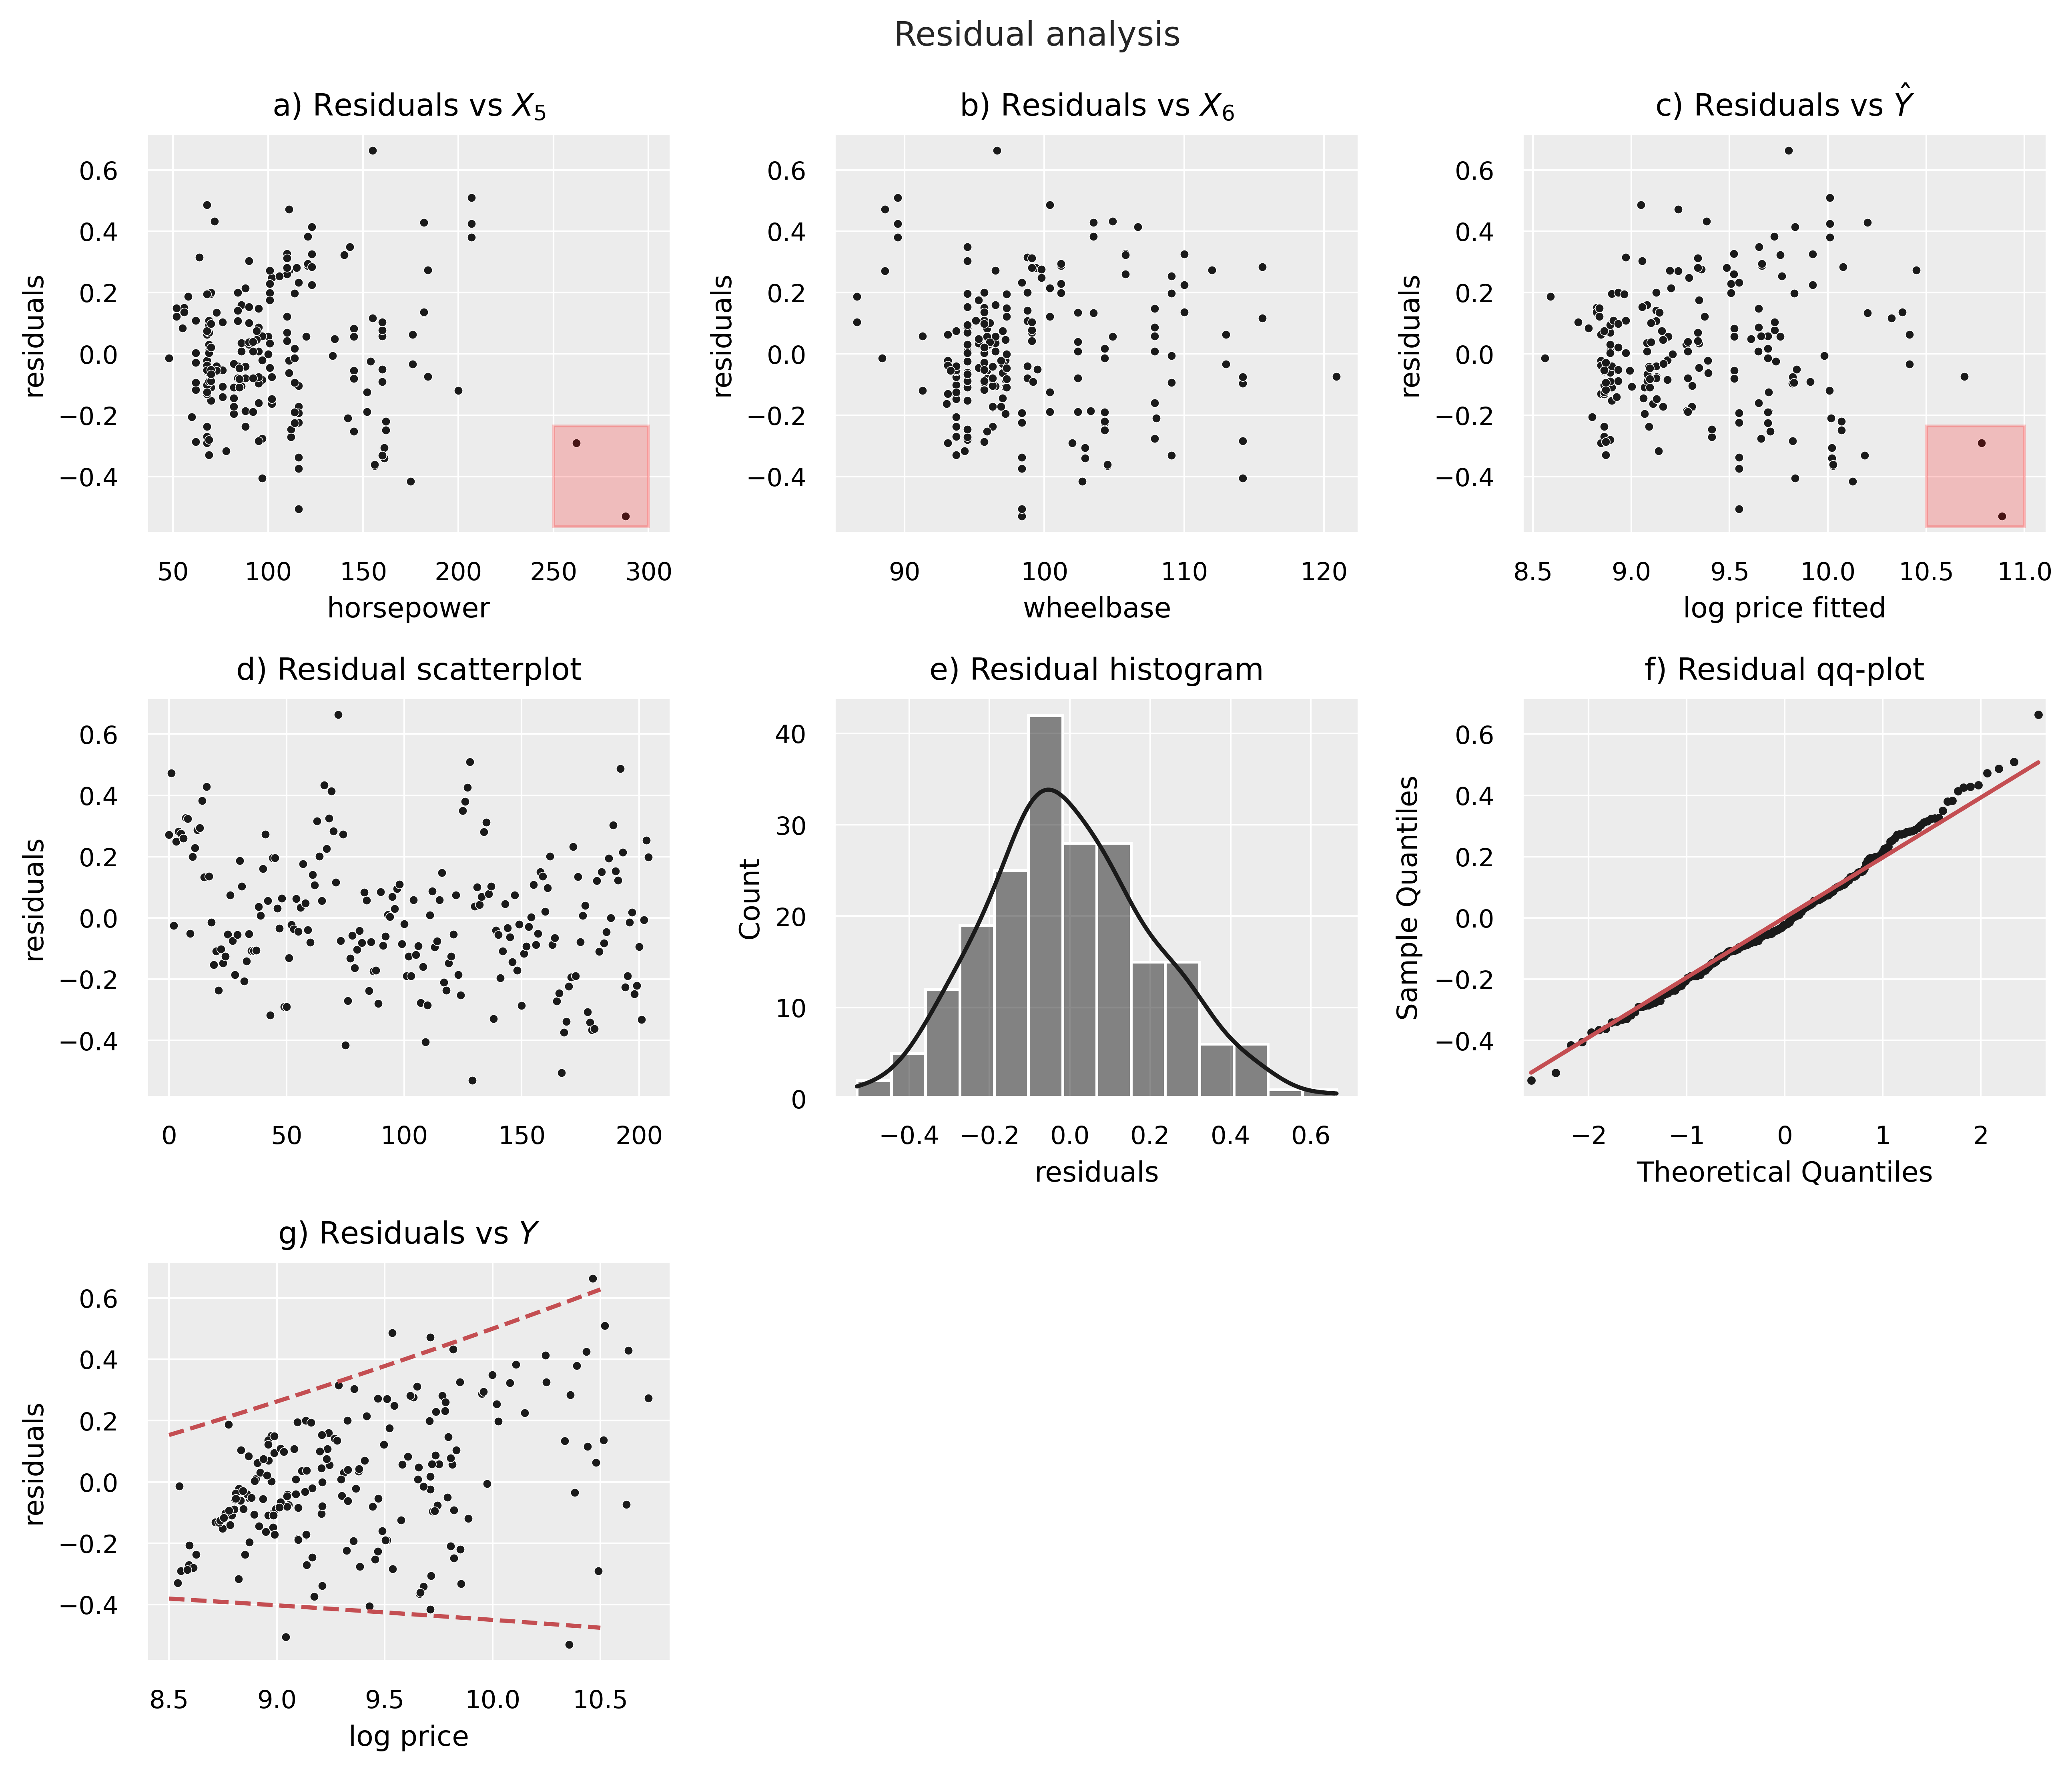

In [11]:
df['log price'] = np.log(df['price'])
model_1_results = pd.DataFrame({'log price fitted': model_1_pred, 'residuals': model_1_fit.resid})

with plt.rc_context(rc = {'figure.dpi': 500, 'axes.labelsize': 10, 
                          'xtick.labelsize': 9, 'ytick.labelsize': 9}): 

    fig_3, ax_3 = plt.subplots(3, 3, figsize = (10.5, 9))
    ax_flat = ax_3.flatten()
    
    ### Plots № 1 - 3
    
    sns.scatterplot(ax = ax_flat[0], y = model_1_results['residuals'], x = df['horsepower'], 
                    s = 9.5, color = 'k')
    
    ax_flat[0].set_title('a) Residuals vs $X_5$', fontsize = 11, color = 'black')
    ax_flat[0].axvspan(xmin = 250, xmax = 300, 
                       ymin = 0.02, ymax = 0.27, 
                       alpha = 0.2, color = 'red')
    
    sns.scatterplot(ax = ax_flat[1], y = model_1_results['residuals'], x = df['wheelbase'],
                    s = 9.5, color = 'k')
    
    ax_flat[1].set_title('b) Residuals vs $X_6$', fontsize = 11, color = 'black')

    sns.scatterplot(ax = ax_flat[2], y = model_1_results['residuals'], 
                    x = model_1_results['log price fitted'], s = 9.5, color = 'k')
    
    ax_flat[2].set_title('c) Residuals vs $\hatY$', fontsize = 11, color = 'black')
    ax_flat[2].axvspan(xmin = 10.5, xmax = 11, 
                       ymin = 0.02, ymax = 0.27, 
                       alpha = 0.2, color = 'red')
    
    ### Plots № 3 - 6
    
    sns.scatterplot(ax = ax_flat[3], y = model_1_results['residuals'], x = Y.index,
                    s = 9.5, color = 'k')
    
    ax_flat[3].set_title('d) Residual scatterplot', fontsize = 11, color = 'black')
    
    sns.histplot(ax = ax_flat[4], x = model_1_results['residuals'], kde = True,
                 color = 'k')
    
    ax_flat[4].set_title('e) Residual histogram', fontsize = 11, color = 'black')
    
    sm.qqplot(model_1_results['residuals'], line = 'q', markerfacecolor = 'k', 
              markeredgecolor = 'k', markersize = 2, ax = ax_flat[5])
    
    ax_flat[5].set_title('f) Residual qq-plot', fontsize = 11, color = 'black')
    
    ### Plot № 7
    
    sns.scatterplot(ax = ax_flat[6], y = model_1_results['residuals'], x = df['log price'],
                    s = 9.5, color = 'k')
    
    ax_flat[6].set_title('g) Residuals vs $Y$', fontsize = 11, color = 'black')
    x_1 = np.linspace(8.5, 10.5, 100)
    ax_flat[6].plot(x_1, -0.01*(x_1/2)**2 - 0.2, color = 'r', linestyle = '--')
    ax_flat[6].plot(x_1, +0.05*(x_1/2)**2 - 0.75, color = 'r', linestyle = '--')
    
    [axes.set_visible(False) for axes in ax_flat[7:]]
    
    fig_3.suptitle('Residual analysis', fontsize = 12)
    plt.tight_layout(pad = 1)
    plt.show()

<p><div style = "text-align: justify; font-size: 16px"><b>Residuals conditioning on $X$</b>:</div></p>

* <div style = "text-align: justify; font-size: 16px">Plot № 3 (c): it can be seen that, overall, there were no obvious patterns. That is exactly what we normally aim to achieve. Nonetheless, it is important to mention that the 2 observations highlighted in red were outliers, probably not the most influential ones, but still;</div>


* <div style = "text-align: justify; font-size: 16px">Plot № 1 (a) and plot № 2 (b) can be helpful in identifying some unusual relationships specific to a particular variable. For instance, the outliers that were spotted on the 3rd graph (c) could be explained through the analysis of the 1st plot (a). After figuring out which variable makes your model worse, you can then explore it further. For example, I decided to check how <span style="color:#003ba8">horsepower</span> was related to <span style="color:#003ba8">log price</span>:</div>

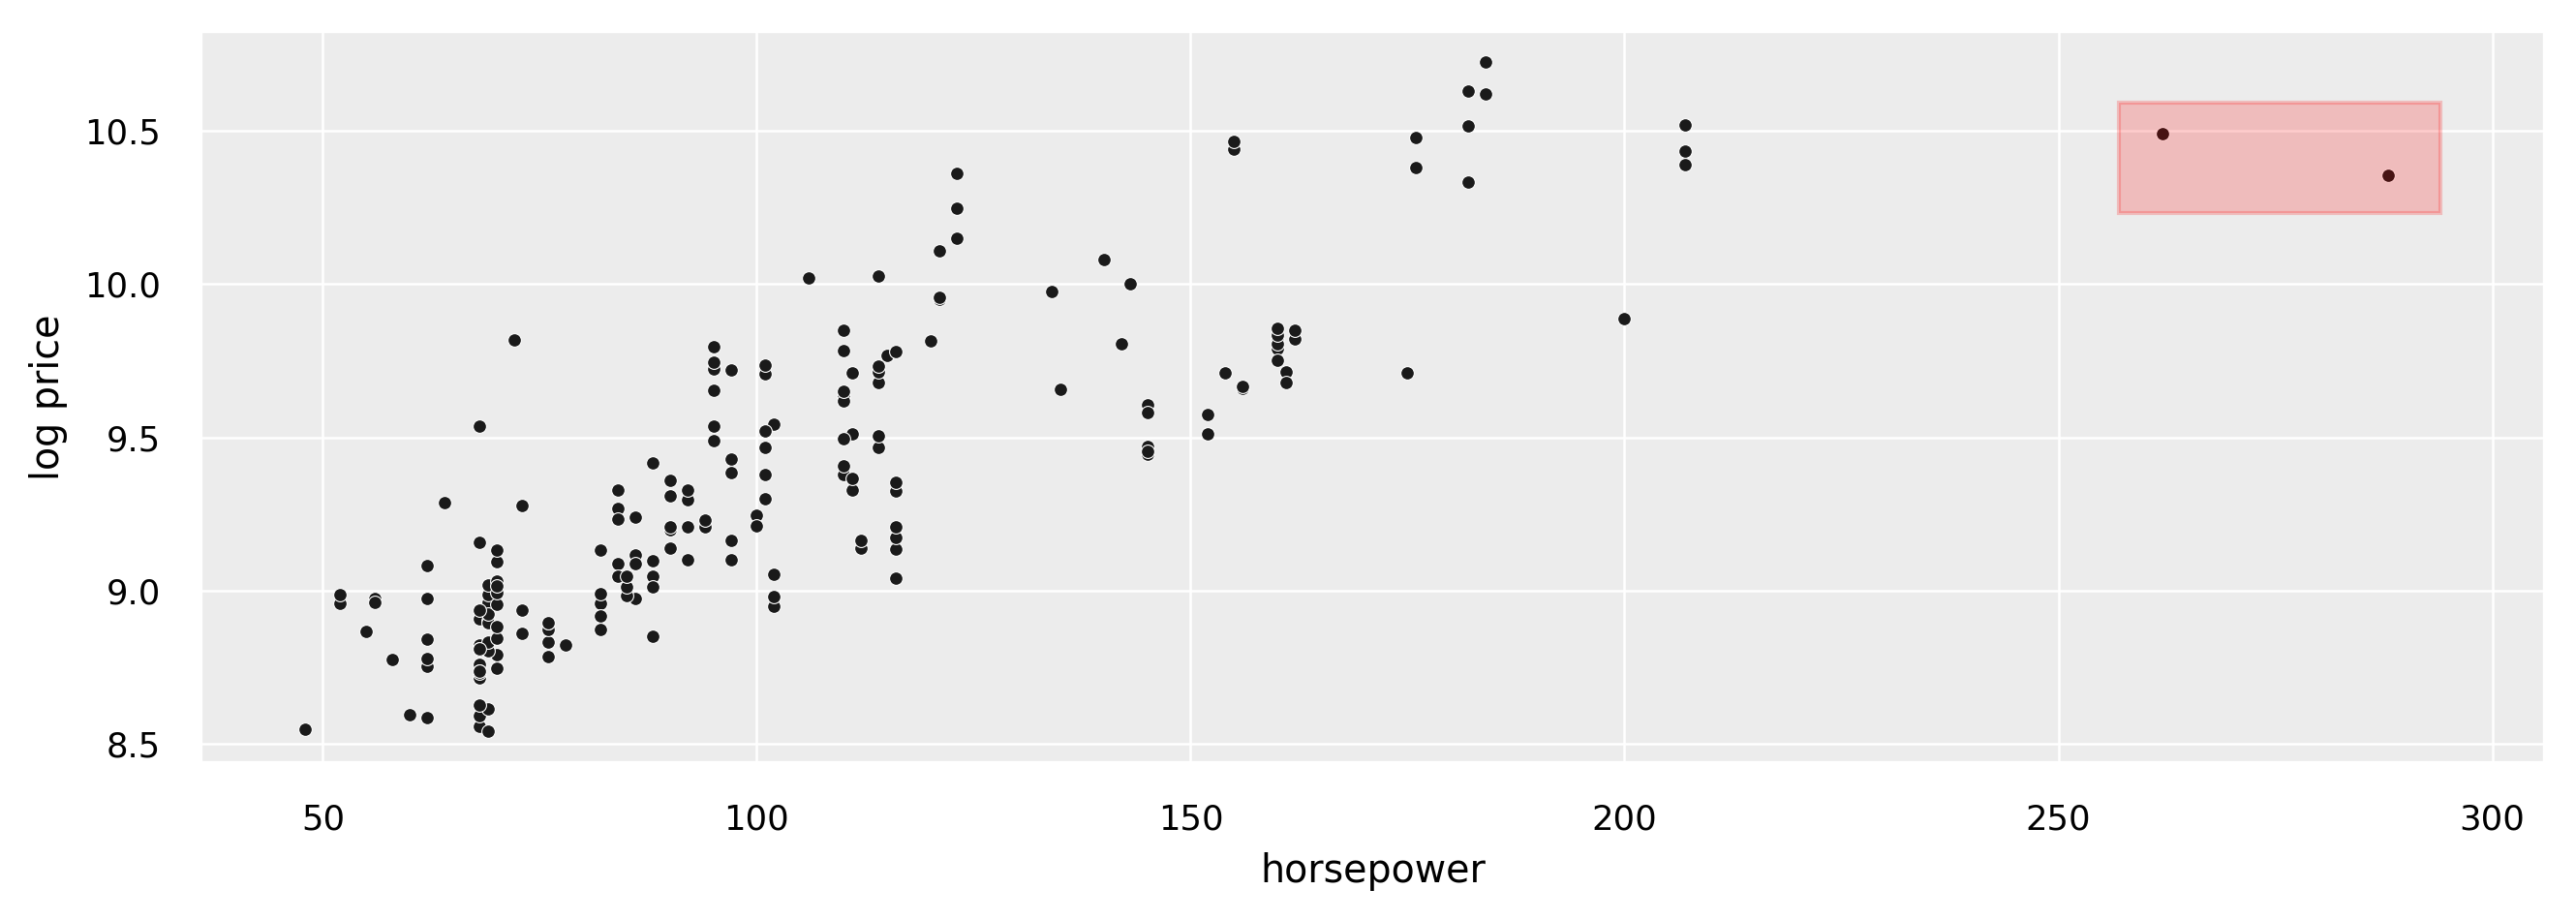

In [12]:
with plt.rc_context(rc = {'figure.dpi': 300, 'axes.labelsize': 9.5, 
                          'xtick.labelsize': 8.5, 'ytick.labelsize': 8.5}): 

    fig_4, ax_4 = plt.subplots(2, 1, figsize = (9, 6))
    ax_flat = ax_4.flatten()
    
    sns.scatterplot(ax = ax_flat[0], y = df['log price'], x = df['horsepower'], 
                    s = 11, color = 'k')
    
    ax_flat[0].axvspan(xmin = 257, xmax = 294, 
                       ymin = 0.75, ymax = 0.9, 
                       alpha = 0.2, color = 'red')
    
    [axes.set_visible(False) for axes in ax_flat[1:]]
    
    plt.tight_layout(pad = 1)
    plt.show()

<p><div style = "text-align: justify; font-size: 16px">One can fairly argue that the highlighted observations our model failed to capture well enough were not at all outliers, and, to some extent, I can agree. Nevertheless, we cannot be sure whether those values were representative of a nonlinear relationship (since we don’t have a sufficient number of similar observations) or they were simply unusual. That is why domain knowledge can be absolutely crucial.</div></p>

<p><div style = "text-align: justify; font-size: 16px"><b>Residual distribution</b>:</div></p>

* <div style = "text-align: justify; font-size: 16px">Plot № 5 (e) and plot № 6 (f) should help us identify what distribution our residuals have. If we see that they are far from being normal, we can opt for GLM or use bootstrap to construct confidence intervals. In this case, residuals were close to be normal; a bit heavy on the right tail, which was the case because of the two "outliers". Note, if your data has some significant outliers, you are better off working with either quantile regression or robust regression;</div>


* <div style = "text-align: justify; font-size: 16px">Plot № 7 (g): as expected, plotting $Y$ against residuals showed some positive correlation, but it was not too strong;</div>


* <div style = "text-align: justify; font-size: 16px">Finally, plot № 4 (d) should look meaningless: no trends, no heteroskedasticity. This model failed to achieve it – we can clearly see some spikes and non-constant variance. Also, when the summary of our model was printed, the value of Durbin-Watson statistic was low (1.094), suggesting autocorrelation. This was discussed more thoroughly a bit later.</div>

<p><div style = "text-align: justify; font-size: 16px">In addition to visual analysis, we can also perform some tests:</div></p>

In [13]:
print('Shapiro-Wilk test: \n', 'p-value:', round(shapiro(model_1_results['residuals'])[1], 3))
print('Anderson-Darling test: \n', 'p-value:', round(normal_ad(model_1_results['residuals'])[1], 3))

Shapiro-Wilk test: 
 p-value: 0.494
Anderson-Darling test: 
 p-value: 0.247


<p><div style = "text-align: justify; font-size: 16px">According to both tests, we did not have enough evidence to conclude that our residuals were not distributed normally (assuming $α = 0.05$).</div></p>

In [14]:
C = pd.DataFrame(het_breuschpagan(model_1_results['residuals'], model_1.exog),
                 index = ['Lm', 'Lm p-value', 'F', 'F p-value'],
                 columns = ['Value']).round(3)

D = pd.DataFrame(het_white(model_1_results['residuals'], model_1.exog),
                 index = ['Lm', 'Lm p-value', 'F', 'F p-value'],
                 columns = ['Value']).round(3)

multi_table([C, D])

<p><div style = "text-align: justify; font-size: 16px">According to both tests, we did not have enough evidence to conclude that our residuals were homoskedastic (assuming $α = 0.05$).</div></p>

<p><div style = "text-align: justify; font-size: 16px"><b>Summary</b>:</div></p>

* <div style = "text-align: justify; font-size: 16px">Heteroskedasticity was present;</div>

* <div style = "text-align: justify; font-size: 16px">Autocorrelation was potentially present. Further analysis was needed;</div>

* <div style = "text-align: justify; font-size: 16px">Residuals were approximately normal.</div>

<p><div style = "text-align: justify; font-size: 16px">Since regressors were picked just for the sake of argument, it was not surpirsing that plenty of problems occurred. Nonetheless, it just showed that visual analysis worked as intended.</div></p>

### 2.3 Autocorrelation. Practice

<div style = "text-align: justify; font-size: 16px">Spotting autocorrelation based on the previous plots might be quite challenging. That is why $ACF$ and $PACF$ plots should be drawn as well:</div>

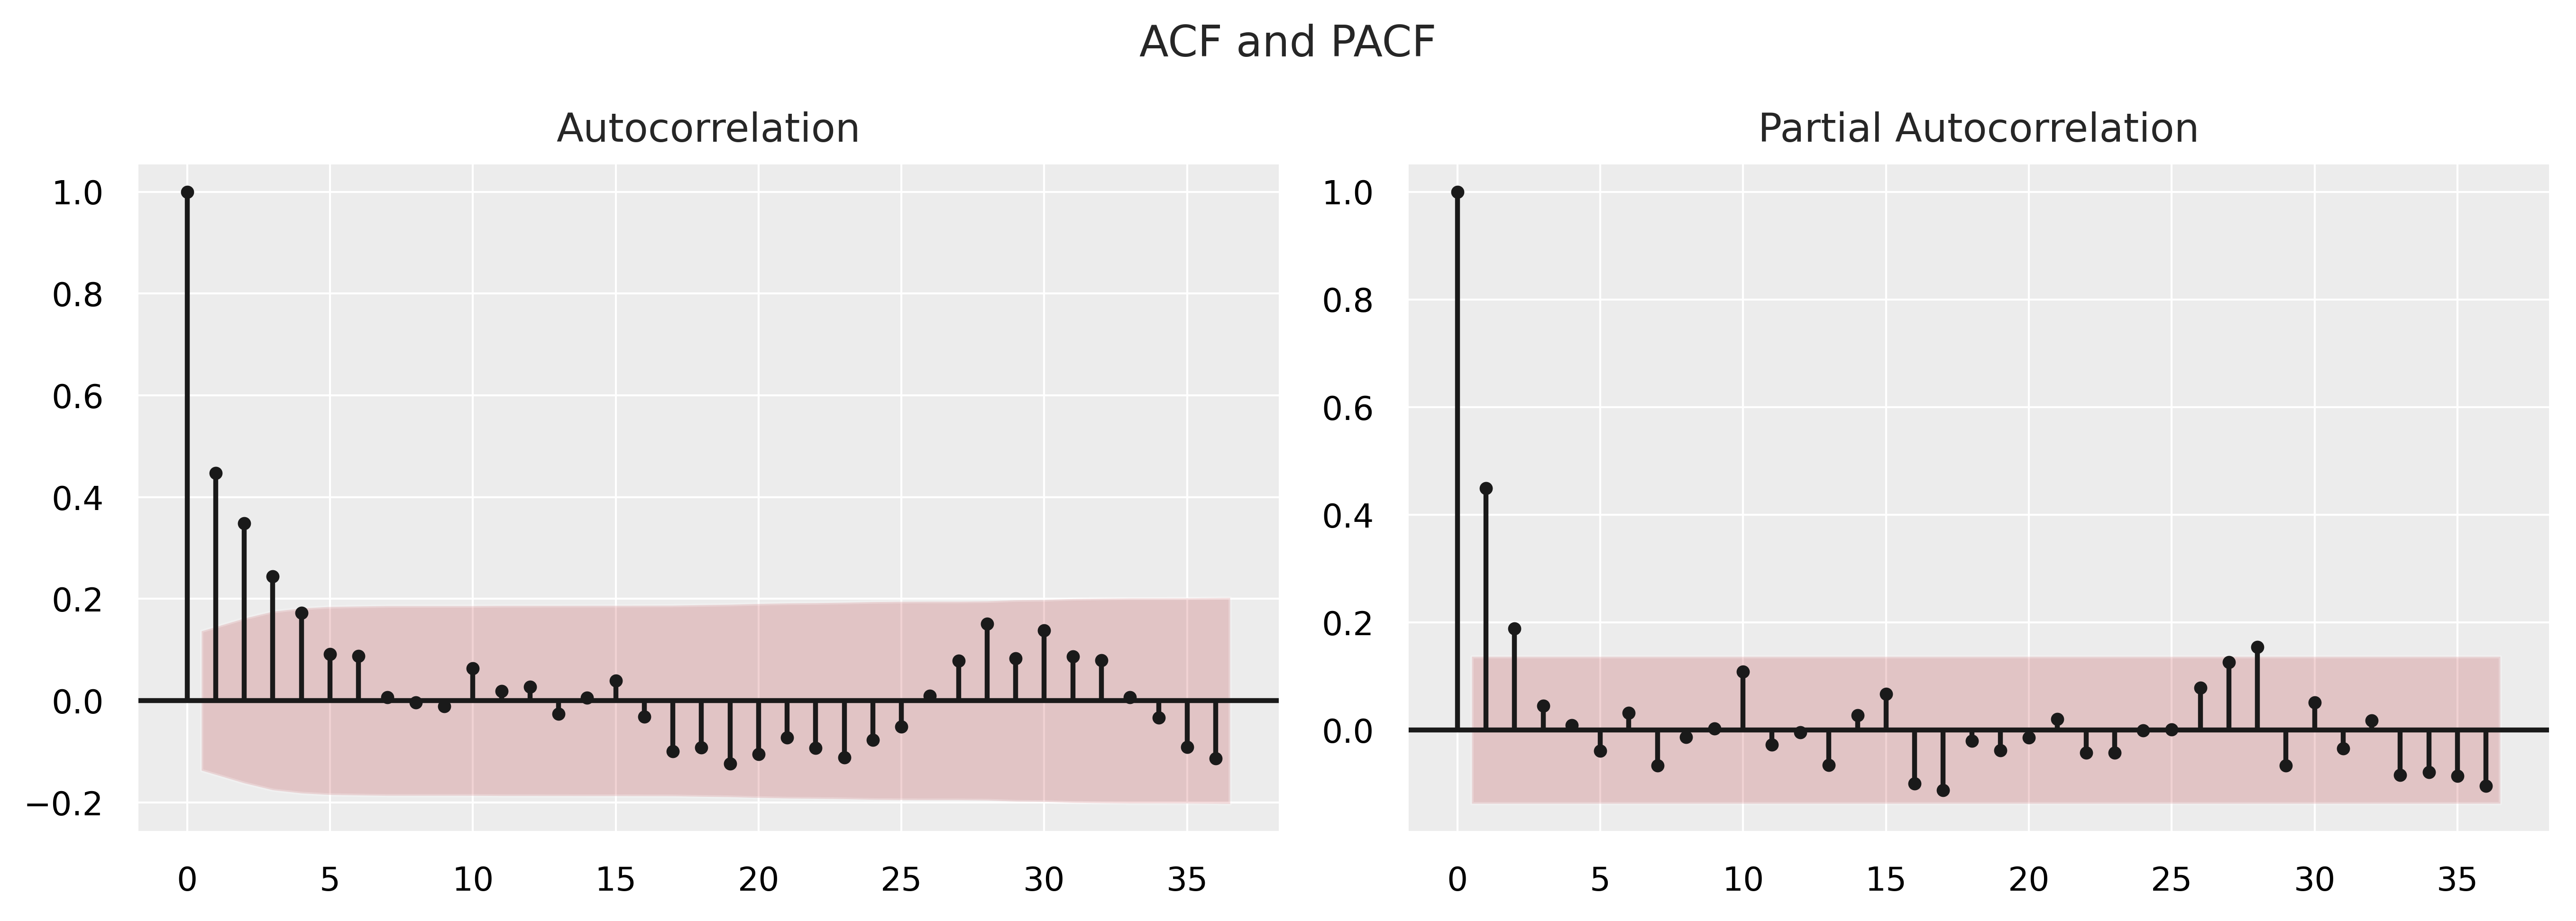

In [15]:
with plt.rc_context(rc = {'figure.dpi': 500, 'axes.labelsize': 11, 
                          'xtick.labelsize': 10, 'ytick.labelsize': 10}): 

    fig_6, ax_6 = plt.subplots(2, 2, figsize = (11, 7))
    ax_flat = ax_6.flatten()

    tsaplots.plot_acf(model_1_results['residuals'], lags = 36, ax = ax_flat[0],
                      markerfacecolor = 'k', markeredgecolor = 'k', markersize = 3,
                      vlines_kwargs={"colors": 'k'})
    
    ax_flat[0].collections[1].set_facecolor('r')
    ax_flat[0].lines[0].set_color('k')
    
    tsaplots.plot_pacf(model_1_results['residuals'], lags = 36, ax = ax_flat[1],
                       markerfacecolor = 'k', markeredgecolor = 'k', markersize = 3,
                       vlines_kwargs={"colors": 'k'})
    
    ax_flat[1].collections[1].set_facecolor('r')
    ax_flat[1].lines[0].set_color('k')

    [axes.set_visible(False) for axes in ax_flat[2:]]
    
    fig_6.suptitle('ACF and PACF', fontsize = 13)
    plt.tight_layout(pad = 1)
    plt.show()

<p><div style = "text-align: justify; font-size: 16px">It is evident that there were multiple significant correlation coefficients. Thus, the presence of autocorrelation was confirmed. Based on $PACF$ plot it can be seen that the second coefficient (lag 2) became barely significant. So, $\hat{ε}_{t-1}$ could explain the autocorrelation structure of the residuals well enough.</div></p>

<p><div style = "text-align: justify; font-size: 16px">I have to admit, having such a strong autocorrelation in panel data is a little odd. Lastly, I performed the Ljung-Box test so as to one more time confirm my findings:</div></p>

In [16]:
acorr_ljungbox(model_1_results['residuals'], lags = 12, model_df = 6, return_df = True)

lb_stat     lb_pvalue
1   41.533022           NaN
2   66.981226           NaN
3   79.493965           NaN
4   85.748378           NaN
5   87.514859           NaN
6   89.159847           NaN
7   89.169593  3.623763e-21
8   89.172892  4.328650e-20
9   89.200396  3.253067e-19
10  90.088810  1.260783e-18
11  90.163441  6.208554e-18
12  90.328611  2.589272e-17

<p><div style = "text-align: justify; font-size: 16px">When the residuals of your model are highly correlated, it makes sense to opt for regression with $ARIMA$ errors because you will not loose interpretability. I have a <a href="https://www.kaggle.com/suprematism/time-series-analysing-and-forecasting">notebook</a> (in $R$) dedciated to the topic of time series where such models were used.</div></p>

<p><div style = "text-align: justify; font-size: 16px">To make this example more complete, I built a model with the same parameters but $ARIMA$ errors:</div></p>

```
Series: df$price 
Regression with ARIMA(1,1,1) errors 
Box Cox transformation: lambda= 0 

Coefficients:
         ar1      ma1  drivewheel_fwd  drivewheel_rwd  aspiration_turbo
      0.5849  -0.9847         -0.0857          0.1233            0.0425
s.e.  0.0745   0.0223          0.0620          0.0736            0.0318
      horsepower  wheelbase
          0.0062     0.0207
s.e.      0.0005     0.0034

sigma^2 estimated as 0.03313:  log likelihood=60.54
AIC=-105.08   AICc=-104.34   BIC=-78.54
```

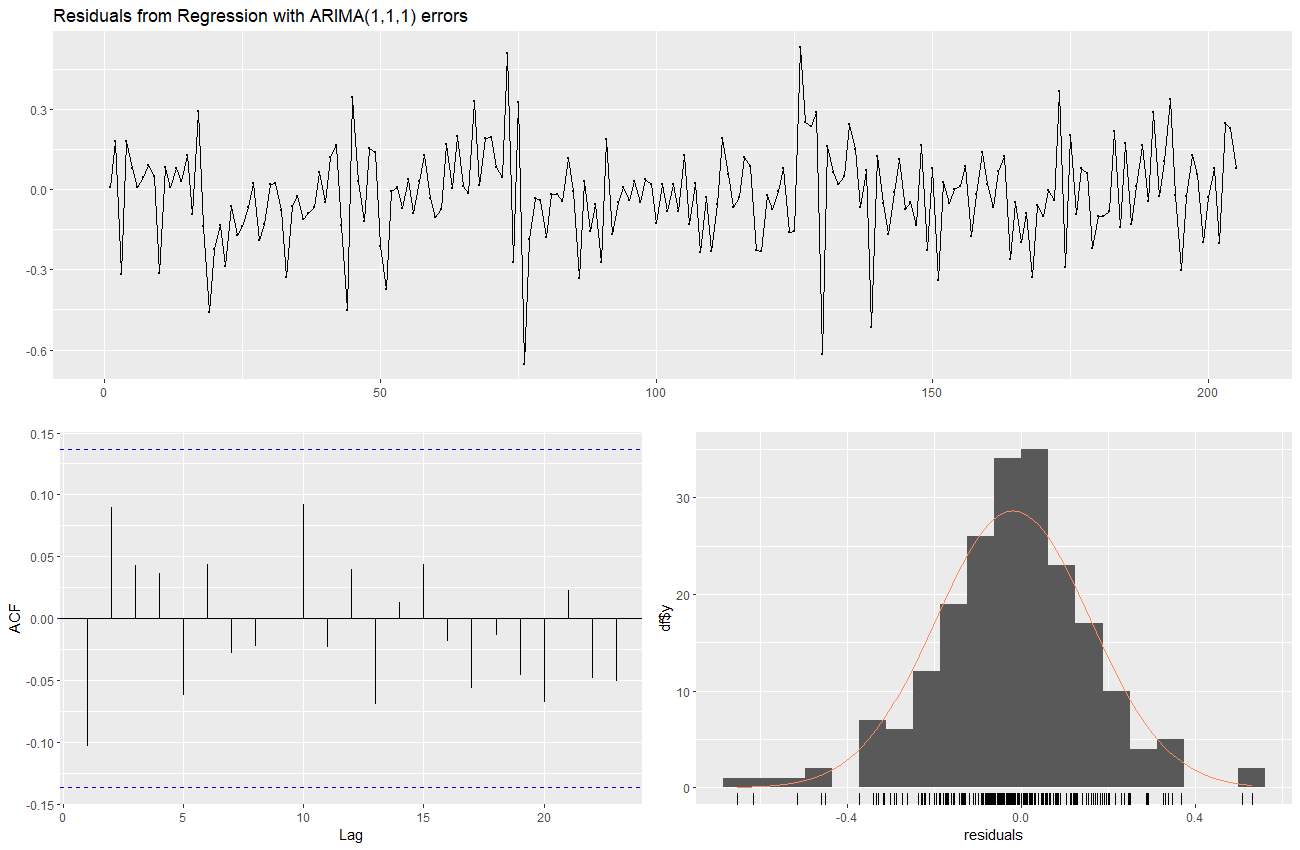

<p><div style = "text-align: justify; font-size: 16px">First, I want to note that the problem of autocorrelation was fully addressed. Second, I believe it is important to mention that the coefficients of our parameters did not change much.</div></p>

## 3. Some notes on how to interpret coefficients of dummy variables <a class="anchor" id = "III_3"></a>

In [17]:
display(model_1_fit.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     193.9
Date:                Wed, 07 Sep 2022   Prob (F-statistic):           1.86e-74
Time:                        20:30:49   Log-Likelihood:                 31.598
No. Observations:                 205   AIC:                            -51.20
Df Residuals:                     199   BIC:                            -31.26
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                5.8585      0.289     20.297      0.000       5.289       6.428
drivewheel_fwd      -0.1011      0.073     -1.380      0.169      -0.245       0.043
drivewheel_rwd       0.0815      0.078      1.038      0.301      -0.073       0.236
aspiration_turbo     0.0027      0.041      0.066      0.947      -0.077       0.083
horsepower           0.0078      0.000     16.621      0.000       0.007       0.009
wheelbase            0.0275      0.003      9.455      0.000       0.022       0.033
==============================================================================
Omnibus:                        2.608   Durbin-Watson:                   1.094
Prob(Omnibus):                  0.272   Jarque-Bera (JB):                2.450
Skew:                           0.268   Prob(JB):                        0.294
Kurtosis:                       3.009   Cond. No.                     2.89e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.89e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<p><div style = "text-align: justify; font-size: 16px">Since significance of dummy variables is interpreted relative to the excluded category, we need additionally test whether included categorical variables are significant at all. To do so, we can use $ANOVA$.</div></p>

<p><div style = "text-align: justify; font-size: 16px"> <b>Source</b>: [<a href="https://stats.stackexchange.com/questions/160026/why-does-an-insignificant-regressor-become-significant-if-i-add-some-significant">1</a>, <a href="https://towardsdatascience.com/statistics-in-python-using-anova-for-feature-selection-b4dc876ef4f0">2</a>].</div></p>

In [18]:
df['log_price'] = np.log(df['price'])

reg_model_drivewheel = ols('log_price' + '~' + 'drivewheel', data = df).fit()
display(sm.stats.anova_lm(reg_model_drivewheel)[0:1])

reg_model_aspiration = ols('log_price' + '~' + 'aspiration', data = df).fit()
display(sm.stats.anova_lm(reg_model_aspiration)[0:1])

df     sum_sq    mean_sq          F        PR(>F)
drivewheel  2.0  24.512115  12.256058  90.795262  7.410259e-29

df    sum_sq   mean_sq          F    PR(>F)
aspiration  1.0  3.431646  3.431646  14.408671  0.000194

<p><div style = "text-align: justify; font-size: 16px">In this model, both <span style="color:#003ba8">drivewheel</span> and <span style="color:#003ba8">aspiration</span> were significant (assuming $α = 0.05$).</div></p>

In [ ]:
feature_list = []

def backwardSelection(df, alpha):
    feature_list = df.columns.tolist()
    
    for i in range(len(splitFitTable(df[feature_list]).pvalues.sort_values(ascending=False))):
        if splitFitTable(df[feature_list]).pvalues.sort_values(ascending=False)[0] < alpha:
            print(splitFitTable(df[feature_list]))
            break
        else:
            print('no', splitFitTable(df[feature_list]).pvalues.sort_values(ascending=False).index.tolist()[0], 'eliminated')
            
            if 'const' not in splitFitTable(df[feature_list]).pvalues.sort_values(ascending=False).index.tolist():
                temp = splitFitTable(df[feature_list]).pvalues.sort_values(ascending=False).index.tolist()[1:]
                feature_list = temp.append('price')
                print('added price')
                
            else:
                feature_list = splitFitTable(df[feature_list]).pvalues.rename(index={'const':'price'}).sort_values(ascending=False).index.tolist()[1:]
                print('ha')